In [ ]:
import pandas as pd
pd.set_option("max_colwidth", 160)
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier

import collections
from keras.preprocessing.text import Tokenizer
from keras import models
from keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from keras.models import Sequential

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences


!pip install -q scikit-plot
import scikitplot as skplt

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")

In [ ]:
def load_data(file_path, indx = True, indx_col = 0):
  '''Parameters:
  file_path: path to your excel or csv file with data,

  indx: boolean - whether there is index column in your file (usually it is the first column) --> *by default it is set to True
  
  indx_col: int - if your file has an index column, specify column number here --> *by default it is equal to 0 (first column)
  '''
  if indx == True and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".xlsx"):
    data = pd.read_excel(file_path)

  elif indx == True and file_path.endswith(".csv"):
    data = pd.read_csv(file_path, index_col = indx_col)
  elif indx == False and file_path.endswith(".csv"):
    data = pd.read_csv(file_path)

  return data

In [ ]:
#!pip install spacy
#!pip install -U spacy --quiet

#!python -m spacy download en_core_web_lg --quiet
#import spacy
#nlp = spacy.load('en_core_web_lg')
#nlp = spacy.load('en_core_web_sm')

In [ ]:
#!python -m spacy download pl_core_news_sm --quiet

#import spacy

# load SPACY model
#nlp = spacy.load('pl_core_news_sm')

In [ ]:
def emotion_category(dataframe, emotive_words_column, affective_database_path, db_words = "Word", db_emotion_category = "Emotion"):
  '''Parameters: 
  dataframe: dataframe with your data,

  content_lemmatized_column: str - name of a column in dataframe where lemmatized text is located,
  
  affective_database_path: str - path to a file with affective database,
  
  db_words: str - name of a column in affective database where words are listed,

  db_emotion_category: str - name of the column from affective database from where the categories will be taken
  '''
  import numpy as np

  if affective_database_path.endswith(".xlsx"):
    affective_database = pd.read_excel(affective_database_path)
  elif affective_database_path.endswith(".csv"):
    affective_database = pd.read_csv(affective_database_path)
  
  affective_database = affective_database[[db_words, db_emotion_category]]
  affective_database.set_index(db_words, inplace=True)
  set_of_words = set(affective_database.index)

  all_emotion_categories = []
  for emotive_words in dataframe[emotive_words_column]:
    adjust_emotion_categories = []
    for word in emotive_words:
      if str(word) in set_of_words:
        emotion_categories = affective_database[[db_emotion_category]].loc[str(word)].values.tolist()
        adjust_emotion_categories.extend(emotion_categories)
    flat_list = []
    for i in adjust_emotion_categories:
      if type(i) == list:
        flat_list.extend(i)
      else:
        flat_list.append(i)
    all_emotion_categories.append(flat_list)
  
  dataframe["Emotion_categories_NRC"] = all_emotion_categories
  return dataframe

In [ ]:
pathos_cols = ['Contains_pathos', 'positive_valence', 'negative_valence',
       'happiness', 'anger', 'sadness', 'fear', 'disgust', 'surprise', 'trust',
       'anticipation']

In [ ]:
def train_all_emotions_multi_category(classifier, classifier_name, x_data, y_label, emotion_names = ['valence']):
  '''
  classifier - model class from scikitlearn package -- pass, for example, MultinomialNB(), 
  
  classifier_name: str - arbitrary name you want to give for a classifier, 
  
  df - dataframe with your data containing input features (X) and labels (y), 

  emotion_names - list with column names in dataframe you want to train separate models for (i.e., something different labels 0 and 1 mean for those columns)

  * test_size = 0.15, 
  * random_state = 3
  '''

  baseline_acc = []
  model_acc = []
  gain_perct = []
  gain_ppoints = []
  emo_name = []
  classif_name = []

  for emotion_name in emotion_names:
    classif_name.append(classifier_name)
    emo_name.append(emotion_name)
    print(f"MODEL TRAINING FOR -->\t {emotion_name}")

    X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size = 0.15, random_state = 3)
    cls_pipe = Pipeline([('count_vector', CountVectorizer()), (classifier_name, classifier)])
    print(f"Model pipeline: {cls_pipe.named_steps}\n")
    cls_pipe.fit(X_train, y_train)
    predictions = cls_pipe.predict(X_test)
    model_score = metrics.accuracy_score(y_test, predictions).round(2)
    model_acc.append(model_score*100)

    dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
    dummy_cls_frq.fit(X_train, y_train)
    predictions_cls_frq = dummy_cls_frq.predict(X_test)
    dummy_score_frq = metrics.accuracy_score(y_test, predictions_cls_frq).round(2)
    baseline_acc.append(dummy_score_frq*100)

    gain = round(((model_score / dummy_score_frq) * 100 - 100), 1)
    gain_perct.append(gain)
    gain_pp = round(((model_score * 100) - (dummy_score_frq *100)), 0)
    gain_ppoints.append(gain_pp)    

    print(f"X_train shape:  {X_train.shape} \t X_test shape:  {X_test.shape}\n")
    print(f"Classification report for {emotion_name} \n{metrics.classification_report(y_test, predictions)}\n")
    print(f"Baseline model accuracy for {emotion_name} --> (most frequent strategy): {dummy_score_frq}\n")
    print(f"Model accuracy: {model_score}")    
    print(f"Gain for model compared with baseline (dummy) model: {gain} percent, \t {gain_pp} p.p.\n")
    print(f"Confusion matrix for {emotion_name}: \n{pd.DataFrame(metrics.confusion_matrix(y_test, predictions))} \n")
    skplt.metrics.plot_confusion_matrix(y_test, predictions, cmap = 'Reds', normalize=True, 
                                        text_fontsize='large', figsize=(6,5))
    plt.title(f"CM for: {classifier_name} and feature: {emotion_name}\n")
    plt.show()
    print("\n\n\n")

  df_results = pd.DataFrame()
  df_results["baseline_acc"] = baseline_acc
  df_results["model_acc"] = model_acc
  df_results["gain_acc_percent"] = gain_perct
  df_results["gain_acc_points"] = gain_ppoints
  df_results["emotion"] = emo_name
  df_results["classifier_name"] = classif_name
  return df_results    

In [ ]:
def train_all_emotions(classifier, classifier_name, df, emotion_names = pathos_cols):
  '''
  classifier - model class from scikitlearn package -- pass, for example, MultinomialNB(), 
  
  classifier_name: str - arbitrary name you want to give for a classifier, 
  
  df - dataframe with your data containing input features (X) and labels (y), 

  emotion_names - list with column names in dataframe you want to train separate models for (i.e., something different labels 0 and 1 mean for those columns)

  * test_size = 0.15, 
  * random_state = 3
  '''

  baseline_acc = []
  model_acc = []
  gain_perct = []
  gain_ppoints = []
  emo_name = []
  classif_name = []

  for emotion_name in emotion_names:
    classif_name.append(classifier_name)
    emo_name.append(emotion_name)

    number_samples = df[emotion_name].sum().astype(int)
    print(f"MODEL TRAINING FOR -->\t {emotion_name}")
    #lab_1 = df[df[emotion_name] == 1]
    #lab_0 = df[df[emotion_name] == 0]
    #lab_0 = lab_0.sample(n=number_samples, random_state=3)
    #df_balanced = pd.concat([lab_0, lab_1])

    df_balanced = df

    # try with Emotive_words (ANEW) and NRC as well
    #x_data = df_balanced.Emotive_words_NRC.apply(lambda x: " ".join(word for word in x)).values # change this value accordingly !!!
    x_data = df_balanced.Text_lemmatized.values
    y_label = df_balanced[emotion_name].values

    X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size = 0.15, random_state = 3)
    cls_pipe = Pipeline([('count_vector', CountVectorizer()), (classifier_name, classifier)])
    print(f"Model pipeline: {cls_pipe.named_steps}\n")
    cls_pipe.fit(X_train, y_train)
    predictions = cls_pipe.predict(X_test)
    model_score = metrics.accuracy_score(y_test, predictions).round(2)
    model_acc.append(model_score*100)

    dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
    dummy_cls_frq.fit(X_train, y_train)
    predictions_cls_frq = dummy_cls_frq.predict(X_test)
    dummy_score_frq = metrics.accuracy_score(y_test, predictions_cls_frq).round(2)
    baseline_acc.append(dummy_score_frq*100)

    gain = round(((model_score / dummy_score_frq) * 100 - 100), 1)
    gain_perct.append(gain)
    gain_pp = round(((model_score * 100) - (dummy_score_frq *100)), 0)
    gain_ppoints.append(gain_pp)    

    print(f"X_train shape:  {X_train.shape} \t X_test shape:  {X_test.shape}\n")
    print(f"Classification report for {emotion_name} \n{metrics.classification_report(y_test, predictions)}\n")
    #print(f"F1-score (beta=2) for {emotion_name}: {round(metrics.fbeta_score(y_test, predictions, beta = 2), 2)}\n")
    print(f"Baseline model accuracy for {emotion_name} --> (most frequent strategy): {dummy_score_frq}\n")

    print(f"Number of instances (items with label 1) for {emotion_name}: {number_samples}\n")
    print(f"Model accuracy: {model_score}")    
    print(f"Gain for model compared with baseline (dummy) model: {gain} percent, \t {gain_pp} p.p.\n")
    print(f"Confusion matrix for {emotion_name}: \n{pd.DataFrame(metrics.confusion_matrix(y_test, predictions))} \n")
    skplt.metrics.plot_confusion_matrix(y_test, predictions, cmap = 'Reds', normalize=True, 
                                        text_fontsize='large', figsize=(6,5))
    plt.title(f"CM for: {classifier_name} and feature: {emotion_name}\n")
    plt.show()
    print("\n\n\n")

  df_results = pd.DataFrame()
  df_results["baseline_acc"] = baseline_acc
  df_results["model_acc"] = model_acc
  df_results["gain_acc_percent"] = gain_perct
  df_results["gain_acc_points"] = gain_ppoints
  df_results["emotion"] = emo_name
  df_results["classifier_name"] = classif_name
  return df_results    

In [ ]:
def lemmatization(dataframe, text_column):
  '''Parameters:
  dataframe: dataframe with your data,
  
  text_column: column of a dataframe where text is located
  '''
  df = dataframe.copy()
  lemmas = []
  for doc in nlp.pipe(df[text_column].apply(str)):
    lemmas.append(" ".join([token.lemma_.lower() for token in doc if (not token.like_num)]).strip())
  df[text_column +"_lemmatized"] = lemmas

  return df

In [ ]:
nrc_emo = load_data("/content/drive/MyDrive/Colab Notebooks/Emotional word lists/nrc_processed.xlsx")

In [ ]:
def model_results_summary(classifier, classifier_name, df, emotion_names = pathos_cols):
  '''
  classifier - model class from scikitlearn package -- pass, for example, MultinomialNB(), 
  
  classifier_name: str - arbitrary name you want to give for a classifier, 
  
  df - dataframe with your data containing input features (X) and labels (y), 

  emotion_names - list with column names

  * test_size = 0.15, 
  * random_state = 3
  '''

  baseline_acc = []
  model_acc = []
  gain_perct = []
  gain_ppoints = []
  emo_name = []
  classif_name = []

  for emotion_name in emotion_names:
    classif_name.append(classifier_name)
    emo_name.append(emotion_name)
    number_samples = df[emotion_name].sum().astype(int)

    lab_1 = df[df[emotion_name] == 1]
    lab_0 = df[df[emotion_name] == 0]
    lab_0 = lab_0.sample(n=number_samples, random_state=3)
    df_balanced = pd.concat([lab_0, lab_1])

    #df_balanced = df

    #x_data = df_balanced["Text_lemmatized"].values # try with Emotive_words (ANEW) and NRC as well (with join w for w)
    x_data = df_balanced.Emotion_categories_NRC.apply(lambda x: " ".join(word for word in x)).values
    y_label = df_balanced[emotion_name].values

    X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size = 0.15, random_state = 3)
    cls_pipe = Pipeline([('count_vector', CountVectorizer()), (classifier_name, classifier)])

    cls_pipe.fit(X_train, y_train)
    predictions = cls_pipe.predict(X_test)
    model_score = metrics.accuracy_score(y_test, predictions).round(2)
    model_acc.append(model_score*100)

    dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
    dummy_cls_frq.fit(X_train, y_train)
    predictions_cls_frq = dummy_cls_frq.predict(X_test)
    dummy_score_frq = metrics.accuracy_score(y_test, predictions_cls_frq).round(2)
    baseline_acc.append(dummy_score_frq*100)

    gain = round(((model_score / dummy_score_frq) * 100 - 100), 1)
    gain_perct.append(gain)
    gain_pp = round(((model_score * 100) - (dummy_score_frq *100)), 0)
    gain_ppoints.append(gain_pp)

  df_results = pd.DataFrame()
  df_results["baseline_acc"] = baseline_acc
  df_results["model_acc"] = model_acc
  df_results["gain_acc_percent"] = gain_perct
  df_results["gain_acc_points"] = gain_ppoints
  df_results["emotion"] = emo_name
  df_results["classifier_name"] = classif_name
  #df_results["method"] = "undersampling_NRC"
  return df_results

In [ ]:
def ml_model_pipe(classifier, classifier_name, x_data, y_label, emotion_name = "Contains_pathos"):
  '''
  classifier - model class from scikitlearn package -- pass, for example, MultinomialNB(), 
  
  classifier_name: str - arbitrary name you want to give for a classifier, 
  
  x_data, y_label - data you will train and test ypur model on

  * test_size = 0.15, 
  * random_state = 3
  '''
  baseline_acc = []
  model_acc = []
  gain_perct = []
  gain_ppoints = []
  emo_name = []
  classif_name = []

  classif_name.append(classifier_name)
  emo_name.append(emotion_name)

  X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size = 0.15, random_state = 3)
  model = classifier
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  model_score = metrics.accuracy_score(y_test, predictions).round(2)
  model_acc.append(model_score*100)

  dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
  dummy_cls_frq.fit(X_train, y_train)
  predictions_cls_frq = dummy_cls_frq.predict(X_test)
  dummy_score_frq = metrics.accuracy_score(y_test, predictions_cls_frq).round(2)
  baseline_acc.append(dummy_score_frq*100)

  gain = round(((model_score / dummy_score_frq) * 100 - 100), 1)
  gain_perct.append(gain)
  gain_pp = round(((model_score * 100) - (dummy_score_frq *100)), 0)
  gain_ppoints.append(gain_pp)

  skplt.metrics.plot_confusion_matrix(y_test, predictions, cmap = 'Reds', normalize=True, 
                                        text_fontsize='large', figsize=(6,5))
  plt.title(f"CM for: {classifier_name} and feature: {emotion_name}\n")
  plt.show()

  df_results = pd.DataFrame()
  df_results["baseline_acc"] = baseline_acc
  df_results["model_acc"] = model_acc
  df_results["gain_acc_percent"] = gain_perct
  df_results["gain_acc_points"] = gain_ppoints
  df_results["emotion"] = emo_name
  df_results["classifier_name"] = classif_name
  
  return df_results

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_float_feat, y_float_feat, test_size = 0.15, random_state = 3)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
count_vect_vocab = count_vect.get_feature_names()
count_vect_vocab

X_train_counts_df = X_train_counts.toarray()
X_train_counts_df = pd.DataFrame(X_train_counts_df)
X_train_counts_df.columns = count_vect_vocab
X_train_counts_df

,abide,ability,able,abnormality,abolish,abortion,absence,absolute,absolve,abstain,abuse,abusive,abyss,accelerate,accept,accidental,accomplish,accord,account,accumulate,accuracy,accurate,accuse,achieve,acquire,act,action,active,activity,actual,add,address,admin,administration,administrative,admire,admission,admit,adult,advance,...,wife,wiki,will,willing,win,window,wine,winner,wipe,wire,wise,wish,wit,withdraw,withhold,witty,woman,wonder,word,work,worker,workout,world,worried,worry,worthy,would,wreck,wrench,write,wrong,wrongdoing,year,yell,yellow,young,youth,zing,zip,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3619,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3620,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3621,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
for word in count_vect_vocab:
  X_train_counts_df[word] = np.where(X_train_counts_df[word] > 0, anew[anew.Word == word]["Valence"].iloc[0], 0)
X_train_counts_df

,abide,ability,able,abnormality,abolish,abortion,absence,absolute,absolve,abstain,abuse,abusive,abyss,accelerate,accept,accidental,accomplish,accord,account,accumulate,accuracy,accurate,accuse,achieve,acquire,act,action,active,activity,actual,add,address,admin,administration,administrative,admire,admission,admit,adult,advance,...,wife,wiki,will,willing,win,window,wine,winner,wipe,wire,wise,wish,wit,withdraw,withhold,witty,woman,wonder,word,work,worker,workout,world,worried,worry,worthy,would,wreck,wrench,write,wrong,wrongdoing,year,yell,yellow,young,youth,zing,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3621,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def model_float_features(classifier, classifier_name, df, emotion_name = "Contains_pathos"):
  '''
  classifier - model class from scikitlearn package -- pass, for example, MultinomialNB(), 
  
  classifier_name: str - arbitrary name you want to give for a classifier, 
  
  x_data, y_label - data you will train and test ypur model on

  * test_size = 0.15, 
  * random_state = 3
  '''
  anew = load_data("/content/drive/MyDrive/Colab Notebooks/laboratorium_magisterskie/anew_v2/anew_val_polarity.xlsx")

  baseline_acc = []
  model_acc = []
  gain_perct = []
  gain_ppoints = []
  emo_name = []
  classif_name = []

  classif_name.append(classifier_name)
  emo_name.append(emotion_name)

  number_samples = df[emotion_name].sum().astype(int)
  lab_1 = df[df[emotion_name] == 1]
  lab_0 = df[df[emotion_name] == 0]
  lab_0 = lab_0.sample(n=number_samples, random_state=3)
  df_balanced = pd.concat([lab_0, lab_1])

  #x_data = df_balanced["Text_lemmatized"].values # try with Emotive_words (ANEW) and NRC as well (with join w for w)
  x_data = df_balanced.Emotive_words_ANEW.apply(lambda x: " ".join(word for word in x)).values
  y_label = df_balanced[emotion_name].values  

  X_train, X_test, y_train, y_test = train_test_split(x_data, y_label, test_size = 0.15, random_state = 3)
  count_vect = CountVectorizer(lowercase=False)
  X_train_counts = count_vect.fit_transform(X_train)
  count_vect_vocab = count_vect.get_feature_names()
  X_train_counts_df = X_train_counts.toarray()

  X_train_counts_df = pd.DataFrame(X_train_counts_df)
  X_train_counts_df.columns = count_vect_vocab

  for word in count_vect_vocab:
    X_train_counts_df[word] = np.where(X_train_counts_df[word] > 0, anew[anew.Word == word]["Valence"].iloc[0], 0)

  X_test = count_vect.transform(X_test)
  X_test_counts_df = X_test.toarray()
  X_test_counts_df = pd.DataFrame(X_test_counts_df)
  X_test_counts_df.columns = count_vect_vocab

  for word in count_vect_vocab:
    X_test_counts_df[word] = np.where(X_test_counts_df[word] > 0, anew[anew.Word == word]["Valence"].iloc[0], 0)
  
  model = classifier
  model.fit(X_train_counts_df.values, y_train)

  predictions = model.predict(X_test_counts_df.values)
  model_score = metrics.accuracy_score(y_test, predictions).round(2)
  model_acc.append(model_score*100)

  dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
  dummy_cls_frq.fit(X_train, y_train)
  predictions_cls_frq = dummy_cls_frq.predict(X_test)
  dummy_score_frq = metrics.accuracy_score(y_test, predictions_cls_frq).round(2)
  baseline_acc.append(dummy_score_frq*100)

  gain = round(((model_score / dummy_score_frq) * 100 - 100), 1)
  gain_perct.append(gain)
  gain_pp = round(((model_score * 100) - (dummy_score_frq *100)), 0)
  gain_ppoints.append(gain_pp)

  skplt.metrics.plot_confusion_matrix(y_test, predictions, cmap = 'Reds', normalize=True, 
                                        text_fontsize='large', figsize=(6,5))
  plt.title(f"CM for: {classifier_name} and feature: {emotion_name}\n")
  plt.show()

  df_results = pd.DataFrame()
  df_results["baseline_acc"] = baseline_acc
  df_results["model_acc"] = model_acc
  df_results["gain_acc_percent"] = gain_perct
  df_results["gain_acc_points"] = gain_ppoints
  df_results["emotion"] = emo_name
  df_results["classifier_name"] = classif_name
  
  return df_results

In [ ]:
data = load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/reddit_PZ.xlsx")
data.fillna(0, inplace = True)
data.shape

(4263, 56)

In [ ]:
data.head(2)

,Num,Node_id,original_text,Text,timestamp,nodeset_id,No_pathos,Contains_pathos,positive_valence,negative_valence,happiness,anger,sadness,fear,disgust,surprise,trust,anticipation,Unsure,Text_lemmatized,Text_lemmatized_split,Emotive_words_ANEW,pos_val_ANEW,neg_val_ANEW,contains_pathos_ANEW,no_pathos_ANEW,Emotive_words_NRC,Emotion_categories_NRC,negative_NRC,positive_NRC,anger_NRC,anticipation_NRC,disgust_NRC,fear_NRC,happiness_NRC,sadness_NRC,surprise_NRC,trust_NRC,Contains_pathos_NRC,No_pathos_NRC,Emotive_words_nrc_intensity,happiness_nrc_intensity,anger_nrc_intensity,sadness_nrc_intensity,fear_nrc_intensity,disgust_nrc_intensity,surprise_nrc_intensity,trust_nrc_intensity,anticipation_nrc_intensity,Polarity_score_ANEW,Negative_polarity_count_ANEW,Positive_polarity_count_ANEW,Negative_polarity_score_ANEW,Positive_polarity_score_ANEW,Negative_percentage_ANEW,Positive_percentage_ANEW
0.0,0.0,196813.0,Emerica : Please someone tell me I'm wrong,Please someone tell me I'm wrong,2002-01-01 14:54:00,10055.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,please someone tell -pron- -pron- be wrong,"['please', 'someone', 'tell', '-pron-', '-pron-', 'be', 'wrong']","[tell, be, wrong]",1.0,1.0,1.0,0.0,[wrong],['negative'],1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,[],0.0000,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,1.0,1.0,1.0,1.0,0.333,0.333
1.0,1.0,196817.0,"Emerica : Take the people who are Bernie supporters, some jump to Webb","Take the people who are Bernie supporters, some jump to Webb",2002-01-01 14:54:00,10055.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"take the people who be bernie supporter , some jump to webb","['take', 'the', 'people', 'who', 'be', 'bernie', 'supporter', ',', 'some', 'jump', 'to', 'webb']","[take, people, be, supporter, jump]",1.0,0.0,1.0,0.0,"[supporter, jump]","['joy', 'positive', 'trust', 'joy', 'positive']",0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,"['supporter', 'jump']",0.2795,0.0,0.0,0.0,0.0,0.0,0.367,0.367,4.0,0.0,4.0,0.0,4.0,0.000,0.800


In [ ]:
data["Text_lemmatized"] = data["Text_lemmatized"].apply(str)
data["Text"] = data["Text"].apply(lambda x: str(x).strip())

from ast import literal_eval
data["Emotive_words_NRC"] = data["Emotive_words_NRC"].apply(literal_eval)
data["Emotive_words_ANEW"] = data["Emotive_words_ANEW"].apply(literal_eval)

In [ ]:
data = lemmatization(data, text_column = "Text")
data

In [ ]:
data = emotion_category(dataframe = data, emotive_words_column = "Emotive_words_NRC", 
                                 affective_database_path = "/content/drive/MyDrive/Colab Notebooks/Emotional word lists/nrc_emotion_category.xlsx")
data.head()

In [ ]:
index_numeric = data[data[['happiness_nrc_intensity', 'anger_nrc_intensity',
       'sadness_nrc_intensity', 'fear_nrc_intensity', 'disgust_nrc_intensity',
       'surprise_nrc_intensity', 'trust_nrc_intensity',
       'anticipation_nrc_intensity']].any(axis=1)].index

In [ ]:
x_numeric = data.loc[index_numeric, ['happiness_nrc_intensity', 'anger_nrc_intensity',
       'sadness_nrc_intensity', 'fear_nrc_intensity', 'disgust_nrc_intensity',
       'surprise_nrc_intensity', 'trust_nrc_intensity',
       'anticipation_nrc_intensity']].values
y_numeric = data.loc[index_numeric, "Contains_pathos"].values

In [ ]:
x_numeric[0] # 8 emotion intesity vector

array([0.27950001, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.36700001, 0.36700001])

In [ ]:
lab_0 = data[data.negative_valence == 1]

lab_1 = data[data.No_pathos == 1]
lab_1 = lab_1.sample(n=1295, random_state=3)

lab_2 = data[data.positive_valence == 1]


lab_1 = lab_1[["Text_lemmatized"]]
lab_1["label"] = 0

lab_0 = lab_0[["Text_lemmatized"]]
lab_0["label"] = -1

lab_2 = lab_2[["Text_lemmatized"]]
lab_2["label"] = 1

data_balance = pd.concat([lab_0, lab_2, lab_1], axis=0)
data_balance.label.value_counts()
# for multi-class sentiment classification

-1    1295
 0    1295
 1     190
Name: label, dtype: int64

In [ ]:
x_tri = data_balance["Text_lemmatized"].values
y_tri = data_balance["label"].values
y_tri.shape, x_tri.shape

In [ ]:
all_x_encode = (pd.DataFrame(np.array(txt).reshape(-1,1)).T for txt in x_sent_encode)
all_x_encode = pd.concat(all_x_encode, ignore_index= True)
all_x_encode.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511
0,-0.022818,0.043824,-0.049381,0.010725,0.043229,-0.069637,0.030497,0.036520,-0.024504,0.047154,-0.014543,0.013039,0.033866,-0.052056,-0.057419,-0.088641,-0.051622,0.019537,0.021105,-0.069291,0.032548,0.003839,-0.002790,0.039666,-0.050564,-0.032032,0.023105,-0.054630,-0.010099,-0.013555,0.006287,-0.027175,0.004659,0.032601,-0.063308,0.015065,-0.031818,-0.010122,-0.034425,0.014940,...,0.010953,-0.062478,0.003015,0.044034,-0.073694,0.061481,-0.034678,-0.013046,-0.009824,0.014734,0.010385,-0.001074,-0.008290,0.054084,-0.054122,0.040106,0.032143,-0.042328,-0.021726,0.051811,0.000017,0.011479,0.015444,-0.054234,0.067129,-0.021246,-0.061421,-0.030546,-0.023231,0.031804,-0.013288,0.028577,0.057448,-0.089987,-0.008941,-0.058338,-0.016418,-0.066861,-0.077915,-0.078834
1,-0.033881,0.042285,-0.028731,-0.025589,0.081963,-0.071465,0.021201,-0.033739,0.012458,0.053662,-0.034976,0.033722,-0.019297,-0.092191,-0.047613,-0.068458,-0.018088,0.036348,0.018677,-0.074321,0.026814,0.003454,-0.018963,0.054987,0.002424,-0.026337,0.043902,-0.054995,-0.000307,0.001002,-0.039299,-0.034548,0.025193,-0.009872,-0.062025,0.020257,-0.067513,-0.018238,-0.045005,0.014523,...,-0.009460,-0.035239,0.017258,0.030518,-0.073899,0.046071,-0.049095,0.019200,-0.009112,0.033680,0.029594,0.026254,-0.038852,0.042081,-0.036571,0.063748,0.032589,-0.000358,-0.002122,0.010821,-0.017234,-0.046248,0.029714,-0.069696,0.059702,-0.040320,-0.002345,-0.040159,-0.007227,0.002941,0.005215,-0.037028,0.046324,-0.075259,-0.033174,-0.067189,-0.020653,-0.063720,-0.063968,-0.076981


In [ ]:
x_encoded = all_x_encode.values

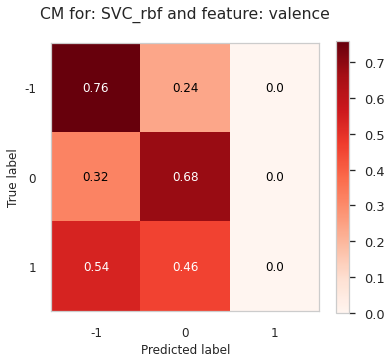

,baseline_acc,model_acc,gain_acc_percent,gain_acc_points,emotion,classifier_name
0,47.0,67.0,42.6,20.0,valence,SVC_rbf


In [ ]:
ml_model_pipe(classifier=SVC(), classifier_name="SVC_rbf", 
              x_data = x_encoded, y_label = y_tri, emotion_name = "valence")

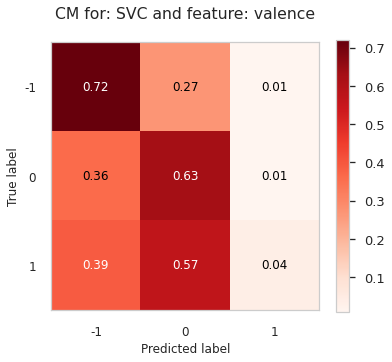

,baseline_acc,model_acc,gain_acc_percent,gain_acc_points,emotion,classifier_name
0,47.0,63.0,34.0,16.0,valence,SVC


In [ ]:
ml_model_pipe(classifier=LinearSVC(max_iter=3000), classifier_name = "SVC", 
              x_data = x_encoded, y_label = y_tri, emotion_name = "valence")

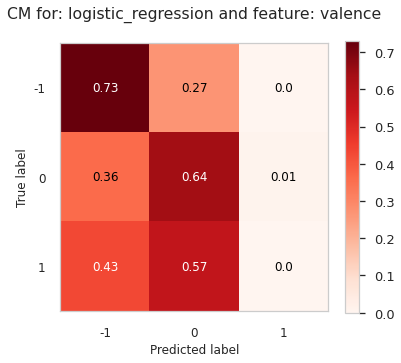

,baseline_acc,model_acc,gain_acc_percent,gain_acc_points,emotion,classifier_name
0,47.0,64.0,36.2,17.0,valence,logistic_regression


In [ ]:
ml_model_pipe(classifier=LogisticRegression(C = 1, max_iter = 1500), classifier_name = "logistic_regression", 
              x_data = x_encoded, y_label = y_tri, emotion_name = "valence")

**model_float_features**

In [ ]:
model_float_features(classifier=LogisticRegression(C = 1, max_iter = 1500), classifier_name = "logistic_regression", 
              df = data, emotion_name = "negative_valence") 

# in count vect values instead of words frequencies now value of valence from anew

In [ ]:
model_float_features(classifier=LinearSVC(max_iter=5000), classifier_name = "SVC", 
              df = data, emotion_name = "anticipation")

In [ ]:
model_float_features(classifier=MultinomialNB(), classifier_name="naive_bayes", 
                     df = data, emotion_name = "Contains_pathos")

**train_all_emotions_multi_category**

MODEL TRAINING FOR -->	 valence
Model pipeline: {'count_vector': CountVectorizer(), 'SVC_rbf': SVC()}

X_train shape:  (2363,) 	 X_test shape:  (417,)

Classification report for valence 
              precision    recall  f1-score   support

          -1       0.66      0.58      0.62       195
           0       0.60      0.75      0.67       194
           1       1.00      0.04      0.07        28

    accuracy                           0.63       417
   macro avg       0.75      0.46      0.45       417
weighted avg       0.65      0.63      0.61       417


Baseline model accuracy for valence --> (most frequent strategy): 0.47

Model accuracy: 0.63
Gain for model compared with baseline (dummy) model: 34.0 percent, 	 16.0 p.p.

Confusion matrix for valence: 
     0    1  2
0  114   81  0
1   48  146  0
2   11   16  1 



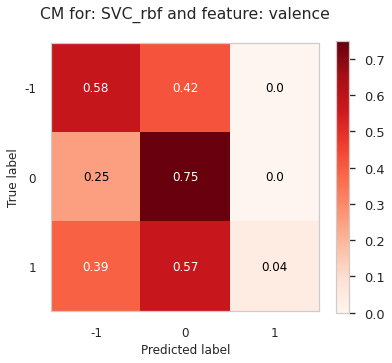

,baseline_acc,model_acc,gain_acc_percent,gain_acc_points,emotion,classifier_name
0,47.0,63.0,34.0,16.0,valence,SVC_rbf


In [ ]:
results_ = train_all_emotions_multi_category(classifier=SVC(), classifier_name = "SVC_rbf", 
                                   emotion_names=["valence"], x_data=x_tri, y_label = y_tri)
results_

**all emotions results count vec**

In [ ]:
results_naive = model_results_summary(classifier=MultinomialNB(), classifier_name="naive_bayes", 
                                      df = data) 
results_naive 

,baseline_acc,model_acc,gain_acc_percent,gain_acc_points,emotion,classifier_name
0,47.0,60.0,27.7,13.0,Contains_pathos,naive_bayes
1,44.0,44.0,0.0,0.0,positive_valence,naive_bayes
2,48.0,50.0,4.2,2.0,negative_valence,naive_bayes
3,42.0,25.0,-40.5,-17.0,happiness,naive_bayes
4,48.0,58.0,20.8,10.0,anger,naive_bayes
5,49.0,50.0,2.0,1.0,sadness,naive_bayes
6,44.0,50.0,13.6,6.0,fear,naive_bayes
7,49.0,51.0,4.1,2.0,disgust,naive_bayes
8,44.0,49.0,11.4,5.0,surprise,naive_bayes
9,39.0,54.0,38.5,15.0,trust,naive_bayes


In [ ]:
results_SVC = train_all_emotions(classifier=LinearSVC(max_iter=3000), classifier_name = "SVC", df = data) 
results_SVC

In [ ]:
results_SVC = model_results_summary(classifier=LinearSVC(max_iter=8000), classifier_name = "SVC", 
                                    df = data)
results_SVC

,baseline_acc,model_acc,gain_acc_percent,gain_acc_points,emotion,classifier_name
0,47.0,62.0,31.9,15.0,Contains_pathos,SVC
1,44.0,58.0,31.8,14.0,positive_valence,SVC
2,48.0,60.0,25.0,12.0,negative_valence,SVC
3,42.0,25.0,-40.5,-17.0,happiness,SVC
4,48.0,59.0,22.9,11.0,anger,SVC
5,49.0,59.0,20.4,10.0,sadness,SVC
6,44.0,62.0,40.9,18.0,fear,SVC
7,49.0,56.0,14.3,7.0,disgust,SVC
8,44.0,59.0,34.1,15.0,surprise,SVC
9,39.0,68.0,74.4,29.0,trust,SVC


In [ ]:
results_logreg = train_all_emotions(classifier=LogisticRegression(C = 1, max_iter = 1500), classifier_name = "logistic_regression", df = data)
results_logreg

In [ ]:
results_logreg = model_results_summary(classifier=LogisticRegression(C = 1, max_iter = 1500), 
                                    classifier_name = "logistic_regression", df = data)
results_logreg

,baseline_acc,model_acc,gain_acc_percent,gain_acc_points,emotion,classifier_name
0,47.0,62.0,31.9,15.0,Contains_pathos,logistic_regression
1,44.0,56.0,27.3,12.0,positive_valence,logistic_regression
2,48.0,60.0,25.0,12.0,negative_valence,logistic_regression
3,42.0,25.0,-40.5,-17.0,happiness,logistic_regression
4,48.0,59.0,22.9,11.0,anger,logistic_regression
5,49.0,59.0,20.4,10.0,sadness,logistic_regression
6,44.0,63.0,43.2,19.0,fear,logistic_regression
7,49.0,47.0,-4.1,-2.0,disgust,logistic_regression
8,44.0,59.0,34.1,15.0,surprise,logistic_regression
9,39.0,64.0,64.1,25.0,trust,logistic_regression


In [ ]:
df_all_ml_results2 = pd.concat([results_logreg, results_naive, results_SVC])
df_all_ml_results2 = pd.concat([df_all_ml_results, df_all_ml_results2])
df_all_ml_results2.reset_index(inplace=True, drop=True)
df_all_ml_results2

**plot training results**

In [ ]:
df_all_ml_results = load_data("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/2nd_round_ml_mlodels.xlsx")
df_all_ml_results.head(1)

,baseline_acc,model_acc,gain_acc_percent,gain_acc_points,emotion,classifier_name,method
0,63,69.0,9.5,6,Contains_pathos,logistic_regression,count_vectorizer


In [ ]:
df_all_ml_results.method.unique()

array(['count_vectorizer', 'undersampling', 'embedding_layer',
       'glove_embeddings', 'count_vectorizer_ANEW',
       'count_vectorizer_NRC', 'undersampling_ANEW', 'undersampling_NRC',
       'undersample_ANEW_float_valence', 'sentence_encoder',
       'ANEW_float_valence', 'NRC_float_emotions', 'AffectVec_embeddings',
       'ANEW_words_glove'], dtype=object)

In [ ]:
df1 = df_all_ml_results[((df_all_ml_results.method=="undersampling") | \
                         (df_all_ml_results.method=="undersampling_ANEW") | \
                         (df_all_ml_results.method=="undersampling_NRC")| \
                         (df_all_ml_results.method=="undersample_ANEW_float_valence")) & \
                        (df_all_ml_results.classifier_name == "logistic_regression")]

df2 = df_all_ml_results[((df_all_ml_results.method=="undersampling") | \
                         (df_all_ml_results.method=="undersampling_ANEW") | \
                         (df_all_ml_results.method=="undersampling_NRC")| \
                         (df_all_ml_results.method=="undersample_ANEW_float_valence")) & \
                        (df_all_ml_results.classifier_name == "SVC")]

In [ ]:
colors_dict = {
    'happiness' : '#8DF903', 'anger' : '#FD7E00', 'sadness' : '#010598', 
                            'fear' : '#000000', 'disgust' : '#6A009B', 'positive_valence' : '#FF1E1E', 
                            'negative_valence' : '#850000', 'anticipation' : '#FF0783', 'trust' : '#FFFB07', 
                            'surprise' : '#02F9EC', 'Contains_pathos': '#007F6F'}

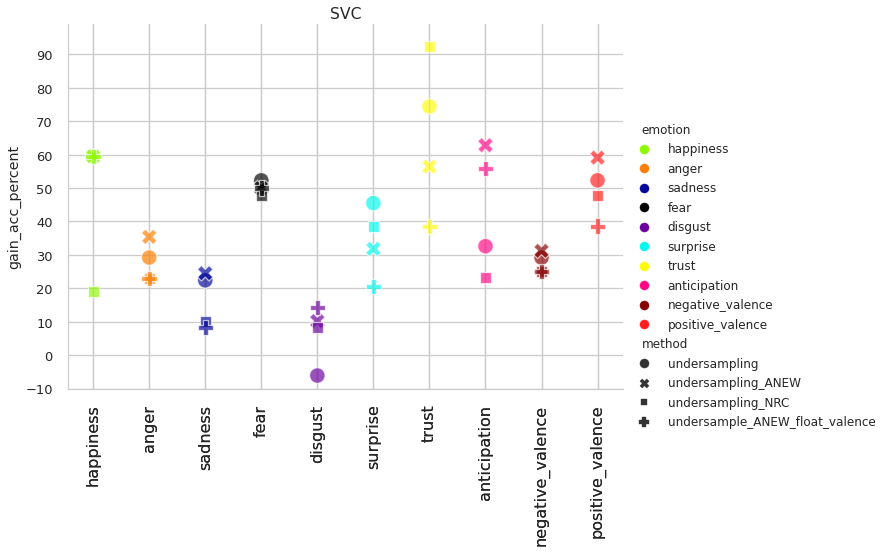

In [ ]:
sns.relplot(kind = "scatter", x="emotion", y="gain_acc_percent", 
            palette = colors_dict, style = "method", data=df2, hue="emotion", aspect=1.5, s=240, alpha=0.68, height = 6)
plt.xticks(x, rotation=90, fontsize=16)
plt.ylim(-10, 99)
plt.yticks(np.arange(-10, 100, 10))
plt.xlabel("")
plt.title("SVC")
plt.show()

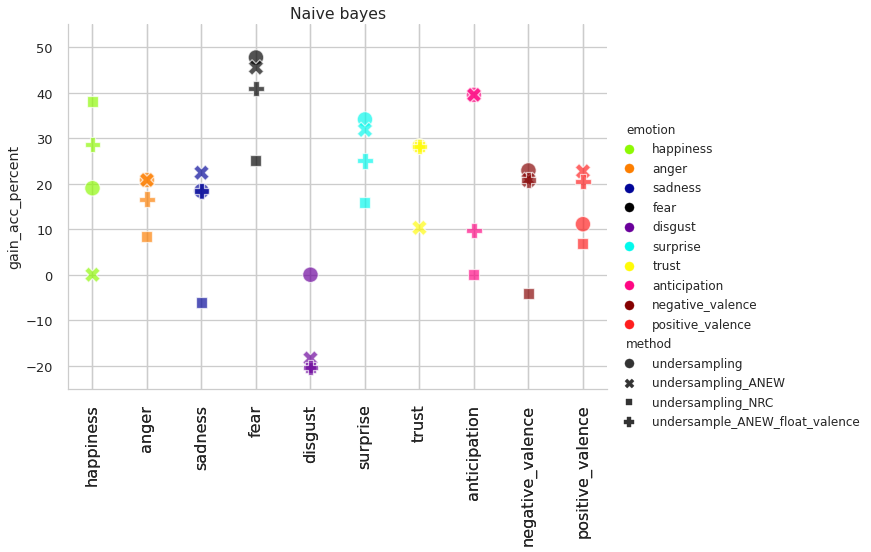

In [ ]:
sns.relplot(kind = "scatter", x="emotion", y="gain_acc_percent", 
            palette = colors_dict, style = "method", data=df2, hue="emotion", aspect=1.5, s=240, alpha=0.68, height = 6)
plt.xticks(x, rotation=90, fontsize=16)
plt.ylim(-25, 55)
plt.xlabel("")
plt.title("Naive bayes")
plt.show()

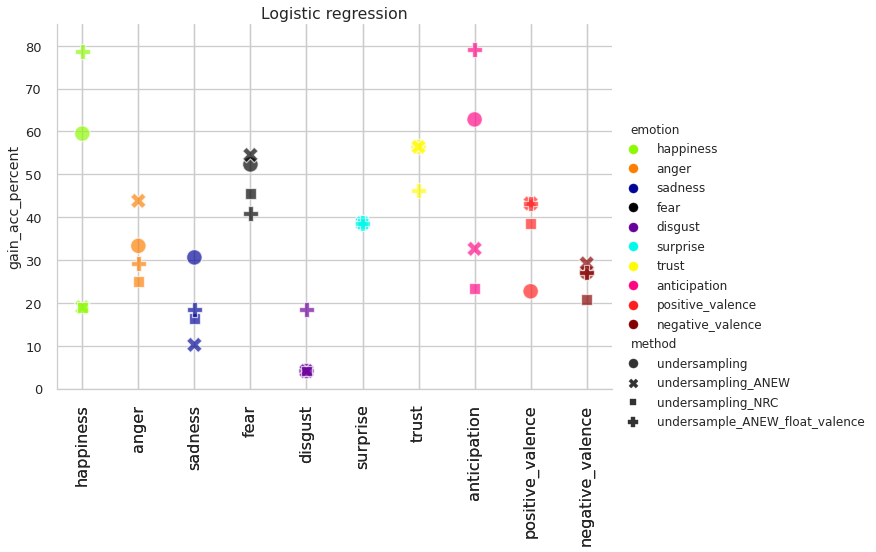

In [ ]:
#plt.figure(figsize=(20, 17))
sns.relplot(kind = "scatter", x="emotion", y="gain_acc_percent", 
            palette = colors_dict, style = "method", data=df1, hue="emotion", aspect=1.5, s=240, alpha=0.68, height = 6)
#plt.xticks(fontsize=16)
plt.xticks(x, rotation=90, fontsize=16)
plt.ylim(0, 85)
plt.xlabel("")
plt.title("Logistic regression")
plt.show()

In [ ]:
fig, ax2 = plt.subplots(1, 1, figsize=(10, 8))
x = list(df_all_ml_results[(df_all_ml_results.method=="undersampling")&(df_all_ml_results.classifier_name == "logistic_regression")]["emotion"])
ax2 = sns.barplot(x="emotion", y="gain_acc_percent", palette = colors_dict,  
            data=df_all_ml_results[(df_all_ml_results.method=="undersampling")&(df_all_ml_results.classifier_name == "logistic_regression")])
#plt.xticks(x, rotation=45, fontsize=16)
ax2.set_xticklabels(x, rotation=50, fontsize=16)
plt.title("Accuracy gain over baseline (%) for logistic regression models")
plt.yticks(fontsize=16)
plt.ylabel("")
plt.ylim(0, 65)
plt.xlabel("")

In [ ]:
sns.set_theme(style="whitegrid")
plt.style.use("seaborn-talk")

x = list(df_all_ml_results[~df_all_ml_results["emotion"].isin({'Contains_pathos', 'valence'})].emotion)
x1 = sns.FacetGrid(df_all_ml_results[~df_all_ml_results["emotion"].isin({'Contains_pathos', 'valence'})], 
                   col="classifier_name", palette = colors_dict, hue='emotion', 
                   height=7.5, aspect=1.5, sharex=False, sharey=False, row = "method")
x1.map(sns.scatterplot, "emotion", "gain_acc_percent", s = 350).set(xticks= x).set_xticklabels(x, 
                                                                                    fontsize=15, 
                                                                                    rotation=25).set(ylabel="\npercent accuracy gain")
#x1.axes[0].set_ylim((-10, 80))                                                                                  
#x1.axes[1].set_ylim((-10, 80))                                                                                  
#x1.axes[2].set_ylim((-10, 80))                                                                                  
x1.axes[0, 0].set_ylabel("\npercent accuracy gain", fontsize = 23)
x1.axes[1, 0].set_ylabel("\npercent accuracy gain", fontsize = 23)
plt.tight_layout()
plt.show()

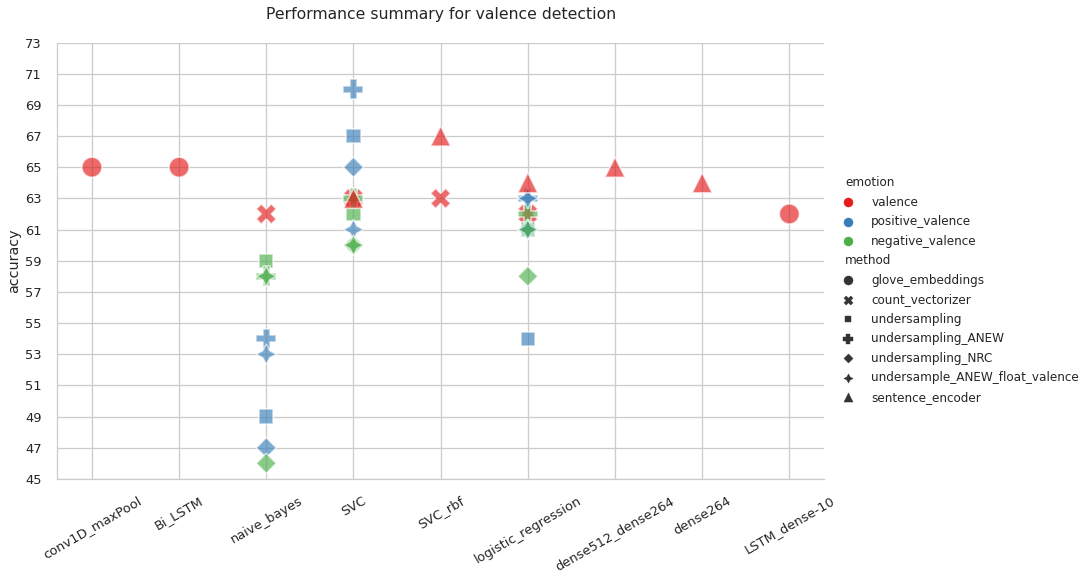

In [ ]:
sns.relplot(data=df_all_ml_results[df_all_ml_results.emotion.isin(['valence', 'positive_valence', 'negative_valence'])], x="classifier_name", y="model_acc", 
          hue = 'emotion', kind="scatter", height=7, aspect=1.7, s = 400, style = "method", alpha=0.65, palette="Set1")
plt.xticks(rotation = 30)
plt.xlabel("")
plt.ylim(45, 73)
plt.ylabel("accuracy")
plt.title("Performance summary for valence detection\n")
plt.yticks(np.arange(45, 74, 2))
plt.show()

In [ ]:
plt.figure(figsize=(10, 15))
sns.relplot(data=df_all_ml_results[df_all_ml_results["emotion"] == "valence"], x="classifier_name", y="model_acc", 
          hue = 'method', kind="scatter", height=7, aspect=1.7, s = 380, style = "method", alpha=0.7, palette="Set1")
#hue = 'method', kind="scatter", height=7, aspect=1.7, s = 300, style = "method", alpha=0.7)
plt.xticks(rotation = 30)
plt.xlabel("")
#plt.ylim(65, 75)
plt.ylabel("accuracy")
plt.title("Performance summary for valence (pos, neg, neutral) detection\n - traditional vs. deep models\n")
#plt.yticks(np.arange(65, 76, 1))
plt.show()

<Figure size 720x1080 with 0 Axes>

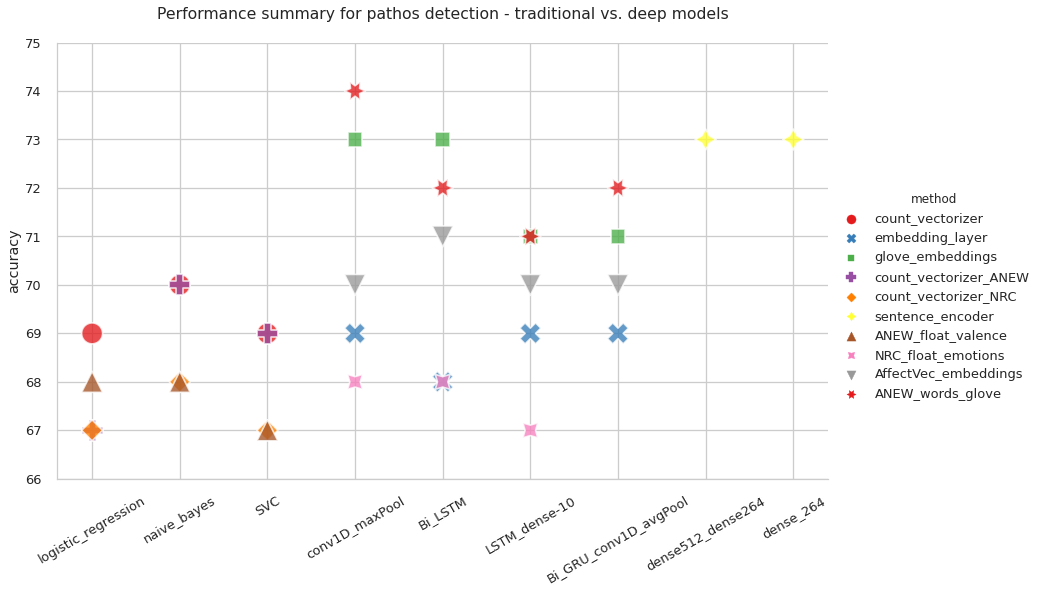

In [ ]:
plt.figure(figsize=(10, 15))
sns.relplot(data=df_all_ml_results[df_all_ml_results["emotion"] == "Contains_pathos"], x="classifier_name", y="model_acc", 
          hue = 'method', kind="scatter", height=7, aspect=1.7, s = 440, style = "method", alpha=0.78, palette="Set1")
#hue = 'method', kind="scatter", height=7, aspect=1.7, s = 300, style = "method", alpha=0.7)
plt.xticks(rotation = 30)
plt.xlabel("")
plt.ylim(66, 75)
plt.ylabel("accuracy")
plt.title("Performance summary for pathos detection - traditional vs. deep models\n")
plt.yticks(np.arange(66, 76, 1))
plt.show()

**Grid search for fine-tuning models parameters - optional**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y_pathos, test_size = 0.15, random_state = 3)
tf_vect = TfidfVectorizer(ngram_range=(1,3))
X_train_tfidf = tf_vect.fit_transform(X_train)
X_train_tfidf.shape

In [ ]:
f_scorer_beta2 = metrics.make_scorer(metrics.fbeta_score, beta=2)

In [ ]:
grid_svm_params = {'kernel': ['poly', 'rbf', 'sigmoid', 'linear'], 
                   'C': list(np.arange(1, 10, 1)), 
                   'class_weight' : ['balanced', {0:1, 1:4}, {0:1, 1:2}]}
grid_svm = GridSearchCV(SVC(), grid_svm_params, cv=5, 
                        return_train_score=True, scoring = f_scorer_beta2)
grid_svm_fit = grid_svm.fit(X_train_tfidf, y_train)
grid_svm_fit.best_score_

In [ ]:
grid_svm_fit.best_params_ 

In [ ]:
gr_results_svm = grid_svm_fit.cv_results_
gr_results_svm = pd.DataFrame(gr_results_svm)
gr_results_svm = gr_results_svm[['param_C', 'param_kernel', 'param_class_weight', 
                                 'mean_test_score', 'std_test_score',
                                 'rank_test_score', 'mean_train_score', 'std_train_score']]
gr_results_svm.head()

In [ ]:
ml_model_pipe(classifier = SVC(kernel = 'sigmoid', C = 1, class_weight = {0:1, 1:4}), 
              classifier_name = "SVC - tuned", 
              x_data=x, y_label=y_pathos)

In [ ]:
plt.figure(figsize=(7, 6))
sns.scatterplot(data = gr_results_svm, x ="param_C", y = "mean_test_score", 
                hue = "param_kernel", alpha = 0.85, style="param_kernel")
plt.show()

#**Keras**

general data preprocessing

In [ ]:
def evaluate_plot(history, metric_name="accuracy", epoch = 10):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    xx = range(1,  epoch+1)

    plt.figure(figsize=(6, 5))
    plt.plot(xx, metric, 'r', label='train ' + metric_name)
    plt.plot(xx, val_metric, 'b', label='validation ' + metric_name)
    plt.legend()
    plt.show()

In [ ]:
maxlen = 34

In [ ]:
x = data["Text_lemmatized"].apply(str).values
y_pathos = data["Contains_pathos"].values # labels: contains pathos - 1, no pathos/unsure - 0

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_tri)
encoded_Y = encoder.transform(y_tri)
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y_pathos, test_size = 0.15, random_state = 3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=3)
X_train.shape, X_valid.shape, X_test.shape

((3260,), (363,), (640,))

**basic model - simple Keras text_to_matrix function with binary or tfidf text vectorization**

In [ ]:
tkn = Tokenizer()#num_words = 5000
tkn.fit_on_texts(X_train)
vocab = len(tkn.word_index) + 1

In [ ]:
X_train_sequence = tkn.texts_to_matrix(X_train, mode = 'binary')
X_test_sequence = tkn.texts_to_matrix(X_test, mode = 'binary')
X_valid_sequence = tkn.texts_to_matrix(X_valid, mode = 'binary')

X_train_sequence[2]

In [ ]:
X_train_sequence.shape

(2126, 3634)

In [ ]:
dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
dummy_cls_frq.fit(X_train_sequence, y_train)
dummy_score_frq = dummy_cls_frq.score(X_test_sequence, y_test).round(2)
dummy_score_frq

In [ ]:
epoch = 10

In [ ]:
X_train_sequence.shape[1]

3634

In [ ]:
model6 = Sequential()
model6.add(Dense(200, input_shape=(X_train_sequence.shape[1],), activation='relu'))
model6.add(layers.Dropout(0.2))
model6.add(Dense(3, activation='softmax'))

model6.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=2e-4), 
               metrics=['accuracy'])
history6 = model6.fit(X_train_sequence, y_train, epochs=epoch, batch_size=64, validation_data=(X_valid_sequence, y_valid), verbose=1)

In [ ]:
evaluate_plot(history6)

In [ ]:
evaluate_plot(history6, 'loss')

In [ ]:
model6.evaluate(X_test_sequence, y_test, batch_size=64)

In [ ]:
results6 = model6.predict(x = X_test_sequence, batch_size=64, verbose=0)
#predictions6 = np.argmax(results6, axis=1)
predictions6 = np.where(results6 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions6)

In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred = predictions6))

In [ ]:
metrics.fbeta_score(y_test, predictions6, beta=2).round(2)

**data preprocessing for model embedding layer without pre-trained weights**

In [ ]:
X_train_sequence = tkn.texts_to_sequences(X_train)
X_test_sequence = tkn.texts_to_sequences(X_test)
X_valid_sequence = tkn.texts_to_sequences(X_valid)

X_train_sequence[2]

[1, 104, 4, 145]

In [ ]:
X_train_seq_pad = pad_sequences(X_train_sequence, padding="post", maxlen=maxlen)
X_test_seq_pad = pad_sequences(X_test_sequence, padding="post", maxlen=maxlen)
X_valid_seq_pad = pad_sequences(X_valid_sequence, padding="post", maxlen=maxlen)

X_train_seq_pad[2]

array([  1, 104,   4, 145,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
x_train = X_train_seq_pad
x_test = X_test_seq_pad
x_valid = X_valid_seq_pad

In [ ]:
x_train[0]

array([   6,  215,   14,    5, 1370,    8,  216,  117,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0], dtype=int32)

In [ ]:
embedding_dim = 100

**Affect-Vec**

In [ ]:
affvec = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/laboratorium_magisterskie/MA_articles/Affect_Vec200/AffectVec-data.txt", 
                     skiprows=1, header=None, engine='python', delim_whitespace=True)
affvec.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239
0,a,-0.0537,-0.0580,-0.0701,0.0472,-0.0491,0.0062,0.1239,-0.0927,0.0750,-0.0495,-0.0311,0.1260,0.0190,-0.0618,0.1686,-0.0954,0.0736,0.0351,-0.0259,-0.0781,-0.0271,0.0438,0.0030,-0.0341,-0.0915,-0.0436,-0.0420,0.1826,-0.0357,0.0677,-0.1584,0.0323,-0.1729,-0.0840,0.0825,-0.0250,-0.0141,0.0218,-0.0629,...,0.0469,-0.0307,-0.0401,-0.0973,0.0206,0.0023,0.0066,0.0596,0.0935,-0.0263,-0.0025,-0.0160,-0.1036,-0.1311,-0.0592,-0.1631,0.0217,-0.1411,0.0094,0.0044,0.0251,0.0023,0.0863,0.0528,-0.0181,0.0150,-0.0336,-0.0237,0.0399,-0.0160,-0.0261,0.0380,0.0116,-0.0577,-0.0187,-0.1015,-0.0279,-0.0694,0.0634,0.0183
1,aa,0.0080,-0.0298,-0.0129,-0.1078,-0.1282,-0.0730,0.0568,-0.0780,0.0053,-0.0398,-0.1232,0.0137,-0.0256,-0.1288,0.1605,-0.1051,0.0131,-0.0209,-0.0910,-0.1068,0.0263,0.0958,-0.0636,-0.0408,-0.1535,-0.0453,-0.1520,-0.0230,-0.0473,0.1159,-0.0067,0.0523,0.0056,0.0181,0.0836,-0.1052,-0.0388,0.0107,0.0264,...,-0.1252,0.0090,0.0090,-0.1013,-0.0430,0.0280,-0.0492,-0.0877,-0.0215,0.0411,-0.0049,-0.0461,-0.0188,-0.0662,-0.0113,-0.0389,0.0405,-0.1421,0.0550,-0.0363,0.0929,0.0763,0.0288,0.0046,-0.0850,-0.0407,-0.1153,-0.0663,0.0981,-0.0246,0.0031,-0.0621,-0.0897,-0.0428,-0.0862,-0.0225,-0.1191,-0.0202,0.0280,0.0409
2,aaa,-0.0231,-0.0482,-0.0417,-0.0749,-0.0491,0.0215,-0.0323,-0.0990,-0.1428,-0.0831,-0.1240,0.0322,-0.0901,-0.1904,-0.0024,-0.0336,-0.0787,-0.1396,-0.0421,-0.1129,-0.0318,-0.0446,-0.0794,-0.0360,-0.0818,-0.0104,-0.1131,-0.1161,-0.0871,0.0785,-0.0680,0.0309,-0.0284,-0.0601,0.0363,-0.1604,-0.1570,-0.0514,0.0159,...,-0.0986,0.0375,-0.0406,-0.1129,-0.0884,-0.0487,-0.0993,-0.0692,-0.0764,-0.0182,-0.0119,-0.0049,-0.1001,-0.1368,-0.0907,-0.1034,-0.0823,-0.1054,0.0120,-0.0884,0.1294,0.1625,-0.0209,-0.0933,-0.0109,0.0239,-0.0511,-0.0241,0.0086,-0.0212,-0.0655,-0.0089,-0.0433,-0.0857,-0.0769,0.0036,-0.1247,-0.0914,0.0089,0.0793
3,aaaa,-0.0161,-0.0675,-0.0905,-0.0936,-0.1137,-0.0675,0.0829,-0.1117,-0.0538,-0.0835,-0.1774,-0.0059,-0.1093,-0.1232,0.0627,-0.0936,-0.0316,-0.0681,-0.1023,-0.1521,0.0137,0.0067,-0.1098,0.0294,-0.0764,-0.0523,-0.1212,-0.0476,-0.1035,0.0270,0.0066,0.0123,0.0417,-0.0000,0.0916,-0.1203,-0.0796,-0.1059,0.0283,...,-0.0902,-0.0363,-0.0078,-0.0526,-0.1155,0.0200,-0.0886,-0.0163,-0.0936,0.0397,-0.0137,-0.0174,-0.0509,-0.1077,-0.0377,-0.0326,0.0074,-0.0853,0.0075,-0.0794,0.1025,0.0302,-0.0670,-0.1333,-0.0700,-0.0447,-0.1091,-0.0584,0.0413,-0.0023,-0.0529,-0.0920,-0.1195,-0.0919,-0.0908,0.0352,-0.1131,0.0005,-0.0154,0.0990
4,aaaaa,0.0408,0.0011,-0.0264,-0.0455,-0.0472,0.0006,-0.0284,-0.0167,-0.0125,-0.0474,-0.0717,-0.0004,-0.0249,0.0025,-0.0052,-0.0100,-0.0379,-0.0547,-0.1027,-0.0608,0.0176,-0.0586,-0.0677,0.0311,0.0088,-0.0596,-0.0430,-0.0492,-0.0260,-0.0355,0.0121,0.0659,0.0624,-0.0419,-0.0071,-0.0773,-0.0506,-0.1441,0.0305,...,-0.0433,0.0655,0.0181,0.0199,-0.0309,0.0066,-0.0552,-0.0562,-0.0480,0.0237,0.0015,0.0580,-0.0131,-0.0794,-0.0511,-0.0548,-0.0314,0.0114,0.0025,-0.0562,0.0856,0.1041,-0.0712,-0.0660,-0.0058,-0.0022,-0.0822,-0.0032,0.0645,-0.0177,-0.0688,-0.0370,-0.0876,-0.0463,-0.0895,0.0353,-0.0905,-0.0162,-0.0160,-0.0077


In [ ]:
affvec.columns = ["dim_"+str(n) for n in range(240)]
affvec = affvec.rename(columns={"dim_0":"Word"})

In [ ]:
affvec["Word"]= affvec.Word.apply(str)

In [ ]:
affvec.head(5)

,Word,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,dim_36,dim_37,dim_38,dim_39,...,dim_200,dim_201,dim_202,dim_203,dim_204,dim_205,dim_206,dim_207,dim_208,dim_209,dim_210,dim_211,dim_212,dim_213,dim_214,dim_215,dim_216,dim_217,dim_218,dim_219,dim_220,dim_221,dim_222,dim_223,dim_224,dim_225,dim_226,dim_227,dim_228,dim_229,dim_230,dim_231,dim_232,dim_233,dim_234,dim_235,dim_236,dim_237,dim_238,dim_239
0,a,-0.0537,-0.0580,-0.0701,0.0472,-0.0491,0.0062,0.1239,-0.0927,0.0750,-0.0495,-0.0311,0.1260,0.0190,-0.0618,0.1686,-0.0954,0.0736,0.0351,-0.0259,-0.0781,-0.0271,0.0438,0.0030,-0.0341,-0.0915,-0.0436,-0.0420,0.1826,-0.0357,0.0677,-0.1584,0.0323,-0.1729,-0.0840,0.0825,-0.0250,-0.0141,0.0218,-0.0629,...,0.0469,-0.0307,-0.0401,-0.0973,0.0206,0.0023,0.0066,0.0596,0.0935,-0.0263,-0.0025,-0.0160,-0.1036,-0.1311,-0.0592,-0.1631,0.0217,-0.1411,0.0094,0.0044,0.0251,0.0023,0.0863,0.0528,-0.0181,0.0150,-0.0336,-0.0237,0.0399,-0.0160,-0.0261,0.0380,0.0116,-0.0577,-0.0187,-0.1015,-0.0279,-0.0694,0.0634,0.0183
1,aa,0.0080,-0.0298,-0.0129,-0.1078,-0.1282,-0.0730,0.0568,-0.0780,0.0053,-0.0398,-0.1232,0.0137,-0.0256,-0.1288,0.1605,-0.1051,0.0131,-0.0209,-0.0910,-0.1068,0.0263,0.0958,-0.0636,-0.0408,-0.1535,-0.0453,-0.1520,-0.0230,-0.0473,0.1159,-0.0067,0.0523,0.0056,0.0181,0.0836,-0.1052,-0.0388,0.0107,0.0264,...,-0.1252,0.0090,0.0090,-0.1013,-0.0430,0.0280,-0.0492,-0.0877,-0.0215,0.0411,-0.0049,-0.0461,-0.0188,-0.0662,-0.0113,-0.0389,0.0405,-0.1421,0.0550,-0.0363,0.0929,0.0763,0.0288,0.0046,-0.0850,-0.0407,-0.1153,-0.0663,0.0981,-0.0246,0.0031,-0.0621,-0.0897,-0.0428,-0.0862,-0.0225,-0.1191,-0.0202,0.0280,0.0409
2,aaa,-0.0231,-0.0482,-0.0417,-0.0749,-0.0491,0.0215,-0.0323,-0.0990,-0.1428,-0.0831,-0.1240,0.0322,-0.0901,-0.1904,-0.0024,-0.0336,-0.0787,-0.1396,-0.0421,-0.1129,-0.0318,-0.0446,-0.0794,-0.0360,-0.0818,-0.0104,-0.1131,-0.1161,-0.0871,0.0785,-0.0680,0.0309,-0.0284,-0.0601,0.0363,-0.1604,-0.1570,-0.0514,0.0159,...,-0.0986,0.0375,-0.0406,-0.1129,-0.0884,-0.0487,-0.0993,-0.0692,-0.0764,-0.0182,-0.0119,-0.0049,-0.1001,-0.1368,-0.0907,-0.1034,-0.0823,-0.1054,0.0120,-0.0884,0.1294,0.1625,-0.0209,-0.0933,-0.0109,0.0239,-0.0511,-0.0241,0.0086,-0.0212,-0.0655,-0.0089,-0.0433,-0.0857,-0.0769,0.0036,-0.1247,-0.0914,0.0089,0.0793
3,aaaa,-0.0161,-0.0675,-0.0905,-0.0936,-0.1137,-0.0675,0.0829,-0.1117,-0.0538,-0.0835,-0.1774,-0.0059,-0.1093,-0.1232,0.0627,-0.0936,-0.0316,-0.0681,-0.1023,-0.1521,0.0137,0.0067,-0.1098,0.0294,-0.0764,-0.0523,-0.1212,-0.0476,-0.1035,0.0270,0.0066,0.0123,0.0417,-0.0000,0.0916,-0.1203,-0.0796,-0.1059,0.0283,...,-0.0902,-0.0363,-0.0078,-0.0526,-0.1155,0.0200,-0.0886,-0.0163,-0.0936,0.0397,-0.0137,-0.0174,-0.0509,-0.1077,-0.0377,-0.0326,0.0074,-0.0853,0.0075,-0.0794,0.1025,0.0302,-0.0670,-0.1333,-0.0700,-0.0447,-0.1091,-0.0584,0.0413,-0.0023,-0.0529,-0.0920,-0.1195,-0.0919,-0.0908,0.0352,-0.1131,0.0005,-0.0154,0.0990
4,aaaaa,0.0408,0.0011,-0.0264,-0.0455,-0.0472,0.0006,-0.0284,-0.0167,-0.0125,-0.0474,-0.0717,-0.0004,-0.0249,0.0025,-0.0052,-0.0100,-0.0379,-0.0547,-0.1027,-0.0608,0.0176,-0.0586,-0.0677,0.0311,0.0088,-0.0596,-0.0430,-0.0492,-0.0260,-0.0355,0.0121,0.0659,0.0624,-0.0419,-0.0071,-0.0773,-0.0506,-0.1441,0.0305,...,-0.0433,0.0655,0.0181,0.0199,-0.0309,0.0066,-0.0552,-0.0562,-0.0480,0.0237,0.0015,0.0580,-0.0131,-0.0794,-0.0511,-0.0548,-0.0314,0.0114,0.0025,-0.0562,0.0856,0.1041,-0.0712,-0.0660,-0.0058,-0.0022,-0.0822,-0.0032,0.0645,-0.0177,-0.0688,-0.0370,-0.0876,-0.0463,-0.0895,0.0353,-0.0905,-0.0162,-0.0160,-0.0077


In [ ]:
affvec.to_csv("/content/drive/MyDrive/Colab Notebooks/laboratorium_magisterskie/MA_articles/Affect_Vec200/AffectVEC.csv")

In [ ]:
affvec_embed = {}
affvec_word_ind = affvec.set_index("Word")
affvec_words = affvec.Word.tolist()

for word in affvec_words:
  affvec_embed[word]= affvec_word_ind.loc[[word]].values[0]

In [ ]:
# SAVE embeddings

import pickle
with open('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/AffectVEC_embeddings.pkl', 'wb') as f:
    pickle.dump(affvec_embed, f)

**creating anew valence and nrc emotion embeddings**

In [ ]:
nrc_embed = {}
nrc_word_ind = nrc_emo_intens1.set_index("word")
nrc_words = nrc_emo_intens1.word.tolist()

for word in nrc_words:
  nrc_embed[word]= nrc_word_ind.loc[[word]].values[0]
nrc_embed

{'aaaaaaah': array([0.   , 0.   , 0.   , 0.344, 0.   , 0.   , 0.   , 0.   ]),
 'aaaah': array([0.   , 0.   , 0.   , 0.234, 0.   , 0.   , 0.   , 0.   ]),
 'abacus': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.406]),
 'abandon': array([0.   , 0.   , 0.   , 0.531, 0.   , 0.703, 0.   , 0.   ]),
 'abandoned': array([0.222, 0.   , 0.   , 0.534, 0.   , 0.828, 0.   , 0.   ]),
 'abandonment': array([0.438, 0.   , 0.   , 0.609, 0.   , 0.859, 0.523, 0.   ]),
 'abbot': array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.438]),
 'abduction': array([0.   , 0.   , 0.   , 0.7  , 0.   , 0.75 , 0.773, 0.   ]),
 'aberration': array([0.   , 0.   , 0.531, 0.   , 0.   , 0.   , 0.   , 0.   ]),
 'abeyance': array([0.   , 0.391, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]),
 'abhor': array([0.816, 0.   , 0.609, 0.547, 0.   , 0.   , 0.   , 0.   ]),
 'abhorrence': array([0.   , 0.   , 0.742, 0.   , 0.   , 0.   , 0.   , 0.   ]),
 'abhorrent': array([0.875, 0.   , 0.68 , 0.672, 0.   , 0.   , 0.  

In [ ]:
# SAVE embeddings

with open('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/nrc_emotion_embeddings.pkl', 'wb') as f:
    pickle.dump(nrc_embed, f)

In [ ]:
anew_embed = {}
anew_word_ind = anew.set_index("Word")
anew_words = anew.Word.tolist()

for word in anew_words:
  anew_embed[word]= np.array([anew_word_ind.loc[[word], "Valence"].iloc[0]])
anew_embed

In [ ]:
# SAVE embeddings
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/anew_valence_embeddings.pkl', 'wb') as f:
    pickle.dump(anew_embed, f)

In [ ]:
# LOAD embeddings
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/reddit_IAA/anew_valence_embeddings.pkl', 'rb') as f:
    embeddings_index = pickle.load(f)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y_tri)
encoded_Y = encoder.transform(y_tri)
dummy_y = np_utils.to_categorical(encoded_Y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_pathos, test_size = 0.15, random_state = 3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=3)
x_train.shape, x_valid.shape, X_test.shape

((3260,), (363,), (640,))

In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=34)
text_ds = tf.data.Dataset.from_tensor_slices(x_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

x_train = vectorizer(np.array([[s] for s in x_train])).numpy()
x_valid = vectorizer(np.array([[s] for s in x_valid])).numpy()
x_test = vectorizer(np.array([[s] for s in x_test])).numpy()

y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 1 #239
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 2145 words (1225 misses)


In [ ]:
embedding_matrix[555:563]

array([[6.1 ],
       [4.9 ],
       [6.9 ],
       [0.  ],
       [0.  ],
       [3.89],
       [5.28],
       [5.72]])

In [ ]:
epoch=10

In [ ]:
model = Sequential()
model.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model.add(layers.Conv1D(30, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
#model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=epoch, batch_size=64, validation_data=(x_valid, y_valid), verbose=1)

In [ ]:
model.evaluate(x_test, y_test, batch_size=64) # poor performance with NRC 8-dim vector

**changing words to pre-trained glove 100d embeddings**

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip -q glove.6B.zip

--2022-01-23 15:20:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-23 15:20:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-23 15:20:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
path_to_glove_file = "/content/drive/MyDrive/Colab Notebooks/Emotional word lists/glove.6B.100d.txt" #"/content/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embeddings_index

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=34)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)

In [ ]:
vectorizer.get_vocabulary()[:10]

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [ ]:
len(voc)

3370

In [ ]:
embeddings_index.get('to')

array([-1.8970e-01,  5.0024e-02,  1.9084e-01, -4.9184e-02, -8.9737e-02,
        2.1006e-01, -5.4952e-01,  9.8377e-02, -2.0135e-01,  3.4241e-01,
       -9.2677e-02,  1.6100e-01, -1.3268e-01, -2.8160e-01,  1.8737e-01,
       -4.2959e-01,  9.6039e-01,  1.3972e-01, -1.0781e+00,  4.0518e-01,
        5.0539e-01, -5.5064e-01,  4.8440e-01,  3.8044e-01, -2.9055e-03,
       -3.4942e-01, -9.9696e-02, -7.8368e-01,  1.0363e+00, -2.3140e-01,
       -4.7121e-01,  5.7126e-01, -2.1454e-01,  3.5958e-01, -4.8319e-01,
        1.0875e+00,  2.8524e-01,  1.2447e-01, -3.9248e-02, -7.6732e-02,
       -7.6343e-01, -3.2409e-01, -5.7490e-01, -1.0893e+00, -4.1811e-01,
        4.5120e-01,  1.2112e-01, -5.1367e-01, -1.3349e-01, -1.1378e+00,
       -2.8768e-01,  1.6774e-01,  5.5804e-01,  1.5387e+00,  1.8859e-02,
       -2.9721e+00, -2.4216e-01, -9.2495e-01,  2.1992e+00,  2.8234e-01,
       -3.4780e-01,  5.1621e-01, -4.3387e-01,  3.6852e-01,  7.4573e-01,
        7.2102e-02,  2.7931e-01,  9.2569e-01, -5.0336e-02, -8.58

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 3202 words (168 misses)


In [ ]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_valid = vectorizer(np.array([[s] for s in X_valid])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [ ]:
X_train[0]

In [ ]:
x_train[0]

In [ ]:
epoch=10

##**Training deep models**

Model 1

In [ ]:
model = Sequential()
#model.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model.add(layers.Conv1D(450, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=epoch, batch_size=64, validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/10
51/51 [==============================] - 4s 63ms/step - loss: 0.6605 - accuracy: 0.6362 - val_loss: 0.6001 - val_accuracy: 0.7107
Epoch 2/10
51/51 [==============================] - 3s 57ms/step - loss: 0.6177 - accuracy: 0.6730 - val_loss: 0.5792 - val_accuracy: 0.7300
Epoch 3/10
51/51 [==============================] - 3s 59ms/step - loss: 0.5871 - accuracy: 0.7040 - val_loss: 0.5605 - val_accuracy: 0.7383
Epoch 4/10
51/51 [==============================] - 3s 57ms/step - loss: 0.5698 - accuracy: 0.7193 - val_loss: 0.5487 - val_accuracy: 0.7521
Epoch 5/10
51/51 [==============================] - 2s 44ms/step - loss: 0.5524 - accuracy: 0.7245 - val_loss: 0.5387 - val_accuracy: 0.7548
Epoch 6/10
51/51 [==============================] - 2s 34ms/step - loss: 0.5365 - accuracy: 0.7371 - val_loss: 0.5394 - val_accuracy: 0.7713
Epoch 7/10
51/51 [==============================] - 2s 33ms/step - loss: 0.5234 - accuracy: 0.7525 - val_loss: 0.5251 - val_accuracy: 0.7576
Epoch 8/10
51

In [ ]:
evaluate_plot(history, 'loss')

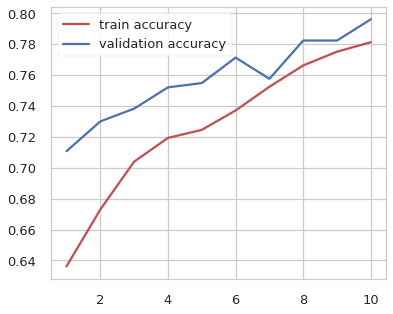

In [ ]:
evaluate_plot(history, 'accuracy')

In [ ]:
print("Evaluate on test data")
model.evaluate(x_test, y_test, batch_size=64)

Evaluate on test data
10/10 [==============================] - 0s 14ms/step - loss: 0.5688 - accuracy: 0.7219


[0.5688062310218811, 0.721875011920929]

In [ ]:
results = model.predict(x = x_test, batch_size=64, verbose=0)
#predictions = np.argmax(results, axis=1)
predictions = np.where(results > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions)

In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred = predictions))

In [ ]:
metrics.fbeta_score(y_test, predictions, beta=2).round(2)

baseline (dummy) classifier for this data

In [ ]:
dummy_cls_frq = DummyClassifier(strategy = "most_frequent", random_state = 3)
dummy_cls_frq.fit(x_train, y_train)
dummy_score_frq = dummy_cls_frq.score(x_test, y_test).round(2)

dummy_cls_strat = DummyClassifier(strategy = "stratified", random_state = 3)
dummy_cls_strat.fit(x_train, y_train)
dummy_score_strat = dummy_cls_strat.score(x_test, y_test).round(2)
dummy_score_frq, dummy_score_strat

(0.63, 0.56)

Model 4

In [ ]:
stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', verbose = 0, patience = 5
)

In [ ]:
model4 = Sequential()
#model4.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model4.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model4.add(layers.Conv1D(250, 3, activation='relu'))
model4.add(layers.Conv1D(150, 5, activation='relu'))
model4.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model4.add(layers.Dropout(0.3))
model4.add(layers.Dense(1, activation='sigmoid'))
#model4.summary()

model4.compile(optimizer=optimizers.Adam(learning_rate=2e-4), loss='binary_crossentropy', metrics=['accuracy'])
history4 = model4.fit(x_train, y_train, epochs=epoch, batch_size=64, validation_data=(x_valid, y_valid), 
                      shuffle=True, verbose=1, callbacks=[stopping])

In [ ]:
evaluate_plot(history4, 'loss')

In [ ]:
evaluate_plot(history4)

In [ ]:
model4.evaluate(x_test, y_test, batch_size=64)

In [ ]:
results4 = model4.predict(x = x_test, batch_size=64, verbose=0)
#predictions4 = np.argmax(results4, axis=1)
predictions4 = np.where(results4 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions4)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predictions4, cmap = 'Reds', normalize=True, text_fontsize='large', figsize=(6,5))
plt.show()

In [ ]:
print(metrics.classification_report(y_test, predictions4))

In [ ]:
metrics.fbeta_score(y_test, predictions4, beta=2).round(2)

Model 2

In [ ]:
model2 = Sequential()
#model2.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model2.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model2.add(layers.Bidirectional(layers.LSTM(100, dropout = 0.1, recurrent_dropout=0.1, activation='relu')))
model2.add(layers.Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))
#model2.summary()

In [ ]:
model2.compile(optimizer=optimizers.Adam(learning_rate=2e-3), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x_train, y_train, epochs=epoch, batch_size=64, 
                    validation_data=(x_valid, y_valid), shuffle=True, verbose=2, callbacks=[stopping])

Epoch 1/10
51/51 - 18s - loss: 0.6497 - accuracy: 0.6479 - val_loss: 0.5703 - val_accuracy: 0.7163 - 18s/epoch - 357ms/step
Epoch 2/10
51/51 - 8s - loss: 0.6709 - accuracy: 0.7009 - val_loss: 0.5975 - val_accuracy: 0.7576 - 8s/epoch - 163ms/step
Epoch 3/10
51/51 - 8s - loss: 0.5908 - accuracy: 0.7083 - val_loss: 0.5466 - val_accuracy: 0.7576 - 8s/epoch - 164ms/step
Epoch 4/10
51/51 - 8s - loss: 0.8210 - accuracy: 0.7206 - val_loss: 0.6338 - val_accuracy: 0.7245 - 8s/epoch - 166ms/step
Epoch 5/10
51/51 - 9s - loss: 0.5502 - accuracy: 0.7313 - val_loss: 0.5176 - val_accuracy: 0.7576 - 9s/epoch - 167ms/step
Epoch 6/10
51/51 - 9s - loss: 0.5240 - accuracy: 0.7482 - val_loss: 0.5172 - val_accuracy: 0.7521 - 9s/epoch - 169ms/step
Epoch 7/10
51/51 - 8s - loss: 0.5264 - accuracy: 0.7497 - val_loss: 0.5066 - val_accuracy: 0.7713 - 8s/epoch - 164ms/step
Epoch 8/10
51/51 - 8s - loss: 0.5155 - accuracy: 0.7466 - val_loss: 0.5082 - val_accuracy: 0.7686 - 8s/epoch - 164ms/step
Epoch 9/10
51/51 - 8s 

In [ ]:
print("Evaluate on test data")
model2.evaluate(x_test, y_test, batch_size=64)

Evaluate on test data
10/10 [==============================] - 1s 29ms/step - loss: 0.5863 - accuracy: 0.7172


[0.5863445997238159, 0.7171875238418579]

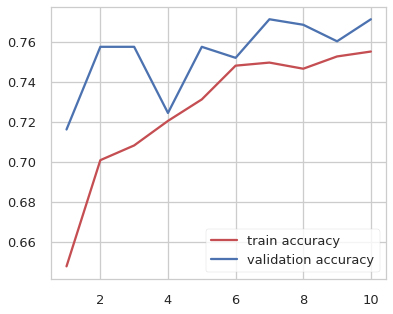

In [ ]:
evaluate_plot(history2)

In [ ]:
results2 = model2.predict(x = x_test, batch_size=64, verbose=0)
#predictions2 = np.argmax(results2, axis=1)
predictions2 = np.where(results2 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions2)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predictions2, cmap = 'Reds', normalize=True, text_fontsize='large', figsize=(6,5))
plt.show()

In [ ]:
print(metrics.classification_report(y_test, predictions2))

In [ ]:
metrics.fbeta_score(y_test, predictions2, beta=2).round(2)

In [ ]:
model3 = Sequential()
#model3.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model3.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model3.add(layers.LSTM(100, activation='tanh', dropout = 0.1, recurrent_dropout=0.1))
model3.add(Dense(10, activation='relu'))
model3.add(layers.Dropout(0.2))
model3.add(Dense(1, activation='sigmoid'))
#model3.summary()

In [ ]:
model3.compile(optimizer=optimizers.Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(x_train, y_train, epochs=epoch, batch_size=64, 
                    validation_data=(x_valid, y_valid), shuffle=True, verbose=2, callbacks=[stopping]) #, class_weight = {0:1, 1:2}

Epoch 1/10
51/51 - 12s - loss: 0.6576 - accuracy: 0.6405 - val_loss: 0.5906 - val_accuracy: 0.7025 - 12s/epoch - 244ms/step
Epoch 2/10
51/51 - 4s - loss: 0.6106 - accuracy: 0.6647 - val_loss: 0.5610 - val_accuracy: 0.7025 - 4s/epoch - 80ms/step
Epoch 3/10
51/51 - 4s - loss: 0.5741 - accuracy: 0.7120 - val_loss: 0.5338 - val_accuracy: 0.7410 - 4s/epoch - 80ms/step
Epoch 4/10
51/51 - 4s - loss: 0.5838 - accuracy: 0.7000 - val_loss: 0.5462 - val_accuracy: 0.7328 - 4s/epoch - 80ms/step
Epoch 5/10
51/51 - 4s - loss: 0.5728 - accuracy: 0.7141 - val_loss: 0.5330 - val_accuracy: 0.7410 - 4s/epoch - 80ms/step
Epoch 6/10
51/51 - 4s - loss: 0.5597 - accuracy: 0.7282 - val_loss: 0.5234 - val_accuracy: 0.7576 - 4s/epoch - 79ms/step
Epoch 7/10
51/51 - 4s - loss: 0.5557 - accuracy: 0.7390 - val_loss: 0.5233 - val_accuracy: 0.7631 - 4s/epoch - 80ms/step
Epoch 8/10
51/51 - 4s - loss: 0.5406 - accuracy: 0.7497 - val_loss: 0.5165 - val_accuracy: 0.7493 - 4s/epoch - 80ms/step
Epoch 9/10
51/51 - 4s - loss:

In [ ]:
evaluate_plot(history3)

In [ ]:
evaluate_plot(history3, "loss")

In [ ]:
model3.evaluate(x_test, y_test, batch_size=64)

10/10 [==============================] - 0s 17ms/step - loss: 0.5712 - accuracy: 0.7172


[0.5712116360664368, 0.7171875238418579]

In [ ]:
results3 = model3.predict(x = x_test, batch_size=64, verbose=0)
#predictions3 = np.argmax(results3, axis=1)
predictions3 = np.where(results3 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions3)

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predictions3, cmap = 'Reds', normalize=True, text_fontsize='large', figsize=(6,5))
plt.show()

In [ ]:
print(metrics.classification_report(y_test, predictions3))

In [ ]:
metrics.fbeta_score(y_test, predictions3, beta=2).round(2)

In [ ]:
model5 = Sequential()
#model5.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model5.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model5.add(layers.Bidirectional(layers.GRU(100, activation='relu', dropout = 0.1, recurrent_dropout=0.1, return_sequences=True)))
model5.add(layers.Conv1D(50, 3, activation='relu'))
model5.add(layers.GlobalAveragePooling1D())
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(1, activation='sigmoid'))
#model5.summary()

In [ ]:
model5.compile(optimizer=optimizers.Adam(learning_rate=25e-5), loss='binary_crossentropy', 
               metrics=['accuracy', keras.metrics.Recall(name = 'recall'), keras.metrics.TruePositives(name = 'true_pos')])
history5 = model5.fit(x_train, y_train, epochs=epoch, batch_size=64, validation_data=(x_valid, y_valid), verbose=2, callbacks=[stopping]) #, class_weight = {0:1, 1:3}

In [ ]:
round(62/47*100-100, 1), 62-47

(31.9, 15)

In [ ]:
evaluate_plot(history5, 'accuracy', epoch=10)

In [ ]:
evaluate_plot(history5, 'recall', epoch=9)

In [ ]:
evaluate_plot(history5, 'true_pos', epoch=9)

In [ ]:
evaluate_plot(history5, 'loss', epoch=9)

In [ ]:
model5.evaluate(x_test, y_test, batch_size=64)

In [ ]:
results5 = model5.predict(x = x_test, batch_size=64, verbose=0)
#predictions5 = np.argmax(results5, axis=1)
predictions5 = np.where(results5 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions5)

array([[374,  32],
       [133, 101]])

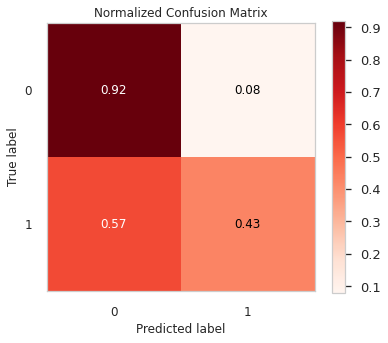

In [ ]:
skplt.metrics.plot_confusion_matrix(y_test, predictions5, cmap = 'Reds', normalize=True, 
                                    text_fontsize='large', figsize=(6,5))
plt.show()

In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred = predictions5))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       406
           1       0.76      0.43      0.55       234

    accuracy                           0.74       640
   macro avg       0.75      0.68      0.68       640
weighted avg       0.75      0.74      0.72       640



In [ ]:
metrics.fbeta_score(y_test, predictions5, beta=2).round(2)

0.47

##**Sentence encoder**

In [ ]:
!pip install tensorflow_text --quiet

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 462 kB 39.6 MB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_text

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3")
# https://tfhub.dev/google/universal-sentence-encoder/4   ENG
# https://tfhub.dev/google/universal-sentence-encoder-multilingual/3 MULTI

In [ ]:
df_pol.tail(3)

In [ ]:
df_pol.shape

(50581, 3)

In [ ]:
x = df_pol["clean_Text"].apply(str).values
#x = data_pol["Text"].apply(str).values # multiemo model trained on full original text w/o cleaning 
y = df_pol["label"].values

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
dummy_y = np_utils.to_categorical(encoded_Y)
dummy_y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
x.shape, dummy_y.shape

((132775,), (132775, 3))

In [ ]:
#x_sent_encode = embed(x)
#x_sent_encode.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, test_size = 0.15, random_state = 3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=3)
x_train.shape, x_valid.shape, x_test.shape

((38693,), (4300,), (7588,))

In [ ]:
x_train

array(['suszarki miały być w pokoju , u nas nie było .',
       'pełnił funkcję kanclerza wyższej szkoły organizacji turystyki i hotelarstwa oraz przewodniczącego rady nadzorczej ost gromada , był prezesem spółki hotelarskiej investon , operatora hoteli ideal .',
       'a jak już się trafi pogoda , to w ogóle musi być super .', ...,
       'jednak trafili śmy na resztki więc wiele nie było .',
       'powiem tak .',
       'lekarze , którzy kolejno zajmowali się mamą ograniczali się jedynie do podleczenia jej bez jakiejkolwiek wizji kompleksowego leczenia - operacyjnego usunięcia ropni i / lub ponownego połączenia jelit .'],
      dtype=object)

In [ ]:
x_train2 = x_train[:15000] # memory issues
x_train3 = x_train[15000:30000]
x_train4 = x_train[30000:45000]
x_train5 = x_train[45000:60000]
x_train6 = x_train[60000:75000]
x_train7 = x_train[75000:90000]
x_train8 = x_train[90000:]

x_train2.shape, x_train5.shape, x_train8.shape

((15000,), (15000,), (11572,))

In [ ]:
x_test2 = x_test[:10000]
x_test3 = x_test[10000:]

In [ ]:
x_valid = embed(x_valid)

x_test2 = embed(x_test2) # memory issues
x_test3 = embed(x_test3)
x_train2 = embed(x_train2)
x_train3 = embed(x_train3)
x_train4 = embed(x_train4)
x_train5 = embed(x_train5)
x_train6 = embed(x_train6)
x_train7 = embed(x_train7)
x_train8 = embed(x_train8)

In [ ]:
x_train_conc = np.concatenate((x_train2, x_train3, x_train4, x_train5, x_train6, x_train7, x_train8), axis=0)

x_test = np.concatenate((x_test2, x_test3), axis=0)

x_train_conc.shape, x_test.shape

((101572, 512), (19917, 512))

In [ ]:
x_train = x_train_conc
x_train.shape

(101572, 512)

In [ ]:
dummy_cls_frq = DummyClassifier(strategy = "stratified", random_state = 3)
dummy_cls_frq.fit(x_train, y_train)
dummy_score_frq = dummy_cls_frq.score(x_test, y_test).round(2)
dummy_score_frq

In [ ]:
# this model architecture takes too long loading everything
# code from: 
# https://colab.research.google.com/github/mrdbourke/tensorflow-deep-learning/blob/main/08_introduction_to_nlp_in_tensorflow.ipynb#scrollTo=ZcbBj0aXqrs9

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-multilingual/3",
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights
                                        name="USE") 

model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(512, activation="relu"),
  layers.Dense(264, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(3, activation="softmax")
], name="model_6_PL_sentiment")

model_6.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=4e-4),
                metrics=["accuracy"])

# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(x_train,
                              y_train,
                              epochs=25,
                              validation_data=(x_valid, y_valid),
                              callbacks=[stopping], 
                              batch_size=64, verbose=1)

model_6.summary()

In [ ]:
stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', verbose = 0, patience = 5
)

In [ ]:
# model trained on minimal cleaning - polemo + muliemo datasets
model7 = Sequential()
model7.add(Dense(512, input_shape=(x_train.shape[1],), activation='relu'))
model7.add(Dense(264, activation='relu'))
model7.add(layers.Dropout(0.2))
model7.add(Dense(3, activation='softmax'))

model7.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=2e-4), 
               metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history7 = model7.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_valid, y_valid), 
                      verbose=1, callbacks=[stopping])

Epoch 1/50
1588/1588 [==============================] - 16s 10ms/step - loss: 0.6870 - accuracy: 0.7120 - recall: 0.6248 - precision: 0.7697 - val_loss: 0.6134 - val_accuracy: 0.7443 - val_recall: 0.6940 - val_precision: 0.7863
Epoch 2/50
1588/1588 [==============================] - 15s 9ms/step - loss: 0.5580 - accuracy: 0.7734 - recall: 0.7276 - precision: 0.8092 - val_loss: 0.5353 - val_accuracy: 0.7797 - val_recall: 0.7412 - val_precision: 0.8130
Epoch 3/50
1588/1588 [==============================] - 15s 9ms/step - loss: 0.4560 - accuracy: 0.8223 - recall: 0.7888 - precision: 0.8503 - val_loss: 0.4753 - val_accuracy: 0.8128 - val_recall: 0.7802 - val_precision: 0.8400
Epoch 4/50
1588/1588 [==============================] - 15s 10ms/step - loss: 0.3578 - accuracy: 0.8679 - recall: 0.8449 - precision: 0.8874 - val_loss: 0.4019 - val_accuracy: 0.8487 - val_recall: 0.8276 - val_precision: 0.8654
Epoch 5/50
1588/1588 [==============================] - 15s 9ms/step - loss: 0.2712 - accu

In [ ]:
model7.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 264)               135432    
                                                                 
 dropout (Dropout)           (None, 264)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 795       
                                                                 
Total params: 398,883
Trainable params: 398,883
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model7.evaluate(x_test, y_test, batch_size=64)

312/312 [==============================] - 1s 5ms/step - loss: 0.2688 - accuracy: 0.9559 - recall: 0.9555 - precision: 0.9567


[0.2688393294811249,
 0.9558668732643127,
 0.9554651975631714,
 0.9566659927368164]

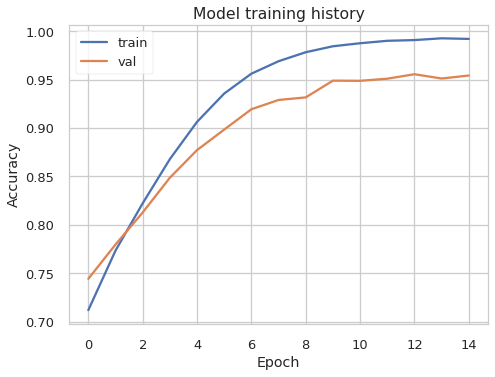

In [ ]:
plt.figure(figsize=(7.5,5.5))
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# model 7

In [ ]:
def f1_score(prec, rec):
  print(f"F1 score:  {round(2*((prec*rec)/(prec+rec)), 3)}")

In [ ]:
f1_score(0.9567, 0.9555) # model 7

F1 score:  0.956


In [ ]:
results7 = model7.predict(x = x_test, batch_size=64, verbose=0)
predictions7 = np.argmax(results7, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print(metrics.classification_report(y_test_labels, predictions7)) # model 7

metrics.f1_score(y_test_labels, predictions7, average="micro").round(3), metrics.f1_score(y_test_labels, predictions7, average="macro").round(3)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      8245
           1       0.95      0.95      0.95      5595
           2       0.96      0.95      0.96      6077

    accuracy                           0.96     19917
   macro avg       0.96      0.95      0.96     19917
weighted avg       0.96      0.96      0.96     19917



(0.956, 0.955)

In [ ]:
# 0 = label negative, 1 = label neutral, 2 = label positive --> see LabelEncoder above

In [ ]:
# multiemo data model
model8 = Sequential()
model8.add(Dense(512, input_shape=(x_train.shape[1],), activation='relu'))
model8.add(Dense(264, activation='relu'))
model8.add(layers.Dropout(0.35))
model8.add(Dense(3, activation='softmax'))

model8.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=1e-4), 
               metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
history8 = model8.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_valid, y_valid), 
                      verbose=1, callbacks=[stopping])

Epoch 1/50
605/605 [==============================] - 8s 10ms/step - loss: 0.8520 - accuracy: 0.6179 - recall_1: 0.3971 - precision_1: 0.7587 - val_loss: 0.7181 - val_accuracy: 0.7042 - val_recall_1: 0.6191 - val_precision_1: 0.7524
Epoch 2/50
605/605 [==============================] - 5s 7ms/step - loss: 0.6939 - accuracy: 0.7133 - recall_1: 0.6453 - precision_1: 0.7589 - val_loss: 0.6827 - val_accuracy: 0.7165 - val_recall_1: 0.6535 - val_precision_1: 0.7601
Epoch 3/50
605/605 [==============================] - 5s 8ms/step - loss: 0.6616 - accuracy: 0.7265 - recall_1: 0.6663 - precision_1: 0.7688 - val_loss: 0.6686 - val_accuracy: 0.7221 - val_recall_1: 0.6616 - val_precision_1: 0.7605
Epoch 4/50
605/605 [==============================] - 5s 7ms/step - loss: 0.6379 - accuracy: 0.7372 - recall_1: 0.6810 - precision_1: 0.7763 - val_loss: 0.6584 - val_accuracy: 0.7226 - val_recall_1: 0.6686 - val_precision_1: 0.7614
Epoch 5/50
605/605 [==============================] - 5s 7ms/step - los

In [ ]:
print(model8.summary())
model8.evaluate(x_test, y_test, batch_size=64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 264)               135432    
                                                                 
 dropout_1 (Dropout)         (None, 264)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 795       
                                                                 
Total params: 398,883
Trainable params: 398,883
Non-trainable params: 0
_________________________________________________________________
None
119/119 [==============================] - 0s 3ms/step - loss: 0.6358 - accuracy: 0.7486 - recall_1: 0.7161 - precision_1: 0.7731


[0.635761022567749, 0.7485503554344177, 0.7161307334899902, 0.773082971572876]

In [ ]:
f1_score(0.7731, 0.7161)

F1 score:  0.744


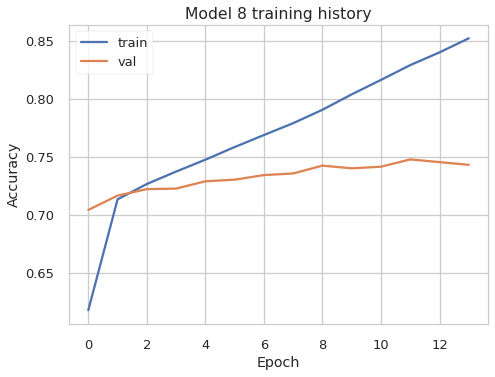

In [ ]:
plt.figure(figsize=(7.5,5.5))
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('Model 8 training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# model 8

In [ ]:
results8 = model8.predict(x = x_test, batch_size=64, verbose=0)
predictions8 = np.argmax(results8, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print(metrics.classification_report(y_test_labels, predictions8)) 

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      3247
           1       0.76      0.71      0.73      2123
           2       0.75      0.70      0.72      2218

    accuracy                           0.75      7588
   macro avg       0.75      0.74      0.74      7588
weighted avg       0.75      0.75      0.75      7588



In [ ]:
metrics.f1_score(y_test_labels, predictions8, average="micro").round(3), metrics.f1_score(y_test_labels, predictions8, average="macro").round(3)

(0.749, 0.743)

In [ ]:
model7.save("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/PL_model_sentiment_recognition_PolEmoMulti_datasets.h5")

**predict expressed sentiment in PL sm**

In [ ]:
df_sm = load_data("/content/drive/MyDrive/Colab Notebooks/debates/validation_samples/tweet_Czerwiec_expressed_sentiment.xlsx")
df_sm.head(2)

In [ ]:
df_sm.shape

In [ ]:
def clean_text2(dataframe, text_column):
  import re
  import string
  df = dataframe.copy()
  all_texts = []
  for text in df[text_column]:
    text = re.sub(r"(http|https):\/\/([\w\s\d\.]+)(\/?)(.*)", " ", str(text).lower()) #  urls
    text = re.sub(r"(www).([\w\s\d\.]+)(\/?)(.*)", " ", text) #  urls
    text = re.sub('@[\w\d]+',' ', text)  # mentions
    text = text.replace("\n", " ") # new lines
    text = re.sub(r'\B#\w*[a-zA-Z0-9]+\w*',' ', text) # hashtags
    text = text.strip()
    all_texts.append(text)
  df["clean_" + text_column+"_MULTIEMO"] = all_texts
  return df

In [ ]:
df_sm = clean_text2(df_sm, text_column = "Tekst")
df_sm.head(2)

In [ ]:
x_sm_conc = df_sm["clean_Tekst_MULTIEMO"].apply(str).values

((10000,), (10000,), (35360,))

In [ ]:
x_sm_conc = embed(x_sm_conc)

In [ ]:
x_sm_conc.shape

(35360, 512)

In [ ]:
pred_sentiment = model7.predict(x = x_sm_conc, batch_size=64, verbose=0)
pred_sentiment_labels = np.argmax(pred_sentiment, axis=1)
pred_sentiment_labels 

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
df_sm["predicted_sentiment"] = pred_sentiment_labels
df_sm.head(3)

In [ ]:
df_sm["predicted_sentiment"] = df_sm["predicted_sentiment"].apply(str)

In [ ]:
lables_sent = {'0': "neg", '1':"neu", '2':'pos'}

df_sm["pred_sentiment_labels"] = df_sm.predicted_sentiment.map(lables_sent)

In [ ]:
df_sm.shape

(35360, 9)

In [ ]:
df_sm.to_excel("/content/drive/MyDrive/Colab Notebooks/debates/validation_samples/tweet_Czerwiec_expressed_sentiment.xlsx")

In [ ]:
def clean_text(dataframe, text_column):
  import re
  import string
  df = dataframe.copy()
  all_texts = []
  for text in df[text_column]:
    text = re.sub(r"(http|https):\/\/([\w\s\d\.]+)(\/?)(.*)", " ", str(text).lower()) #  urls
    text = re.sub(r"(www).([\w\s\d\.]+)(\/?)(.*)", " ", text) #  urls
    text = re.sub('@[\w\d]+',' ', text)  # mentions
    text = text.replace("\n", " ") # new lines
    text = re.sub(r'\B#\w*[a-zA-Z0-9]+\w*',' ', text) # hashtags
    text = re.sub("""[!"'#$%&()*+,-./:;<=>?@[\]^_`{|}~]""", ' ', text) # punctuation marks
    text = re.sub(r'[0-9]', '', text)
    text = text.strip()
    text = re.sub(r'\s\s+', ' ', text)
    all_texts.append(text)
  df["clean_" + text_column] = all_texts

  return df

In [ ]:
df_pol = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/clarin_polelmo2/dataset_conll/Nmedicine.sentence.train.txt", 
                     sep = " __", header=None, engine='python')
print(df_pol.shape)
df_pol.head(2)

(27848, 2)


,0,1
0,Jednak standard pozostawia do życzenia ; zwłaszcza przy cenie ponad 500 zł . ( weekend ) za dobę można oczekiwać więcej .,label__z_minus_m
1,Czynne były również sauny - parowa i sucha .,label__z_zero


In [ ]:
df_pol22 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/clarin_polelmo2/dataset_conll/Nproducts.sentence.train.txt", 
                     sep = " __", header=None, engine='python')
print(df_pol22.shape)
df_pol22.head(2)

(40032, 2)


,0,1
0,"08 - 20 , sauny od 16 - tej , masaze .",label__z_zero
1,"Dr Sopylo jest miłym człowiekiem , bada delikatnie , wysłuchuje cierpliwie i sporo tłumaczy .",label__z_plus_m


In [ ]:
df_pol33 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/clarin_polelmo2/dataset_conll/Nhotels.sentence.train.txt", 
                     sep = " __", header=None, engine='python')
print(df_pol33.shape)
df_pol33.head(2)

(26093, 2)


,0,1
0,"Koła były trudne , lecz Dr Całka twierdził , że są to podstawowe zadanka .",label__z_minus_m
1,Tłok czasem zdaje się zawadzać o cylinder ( słychać metaliczny dźwięk ) .,label__z_minus_m


In [ ]:
df_pol = pd.concat([df_pol, df_pol22, df_pol33], axis=0)
df_pol.head(2)

,0,1
0,Jednak standard pozostawia do życzenia ; zwłaszcza przy cenie ponad 500 zł . ( weekend ) za dobę można oczekiwać więcej .,label__z_minus_m
1,Czynne były również sauny - parowa i sucha .,label__z_zero


In [ ]:
df_pol.shape

(93973, 2)

In [ ]:
df_pol.columns = ["Text", "label"]
df_pol.label.unique()

array(['label__z_minus_m', 'label__z_zero', 'label__z_plus_m',
       'label__z_amb'], dtype=object)

In [ ]:
df_pol = df_pol[df_pol.label != 'label__z_amb']
df_pol.shape

(82194, 2)

In [ ]:
data_pol = clean_text2(df_pol, text_column = "Text")
data_pol.head()

,Text,label,clean_Text
0,Jednak standard pozostawia do życzenia ; zwłaszcza przy cenie ponad 500 zł . ( weekend ) za dobę można oczekiwać więcej .,label__z_minus_m,jednak standard pozostawia do życzenia ; zwłaszcza przy cenie ponad 500 zł . ( weekend ) za dobę można oczekiwać więcej .
1,Czynne były również sauny - parowa i sucha .,label__z_zero,czynne były również sauny - parowa i sucha .
2,Zdecydowanie nie polecam .,label__z_minus_m,zdecydowanie nie polecam .
3,TiTS - wykład OCENA : moze byc Pan Leszek tłumaczy jak krowie na rowie - jak dzieciom w podstawówce ! ! !,label__z_plus_m,tits - wykład ocena : moze byc pan leszek tłumaczy jak krowie na rowie - jak dzieciom w podstawówce ! ! !
6,"Obawiali śmy się tłumu - w końcu to niedziela , święto , no i 3 dni po emisji programu .",label__z_zero,"obawiali śmy się tłumu - w końcu to niedziela , święto , no i 3 dni po emisji programu ."


In [ ]:
data_pol.label.value_counts()

label__z_minus_m    34200
label__z_plus_m     25299
label__z_zero       22695
Name: label, dtype: int64

In [ ]:
lables_num = {'label__z_minus_m':-1, 'label__z_plus_m':1, 'label__z_zero':0}

data_pol["label"] = data_pol.label.map(lables_num)
data_pol.head()

,Text,label,clean_Text
0,Jednak standard pozostawia do życzenia ; zwłaszcza przy cenie ponad 500 zł . ( weekend ) za dobę można oczekiwać więcej .,-1,jednak standard pozostawia do życzenia ; zwłaszcza przy cenie ponad 500 zł . ( weekend ) za dobę można oczekiwać więcej .
1,Czynne były również sauny - parowa i sucha .,0,czynne były również sauny - parowa i sucha .
2,Zdecydowanie nie polecam .,-1,zdecydowanie nie polecam .
3,TiTS - wykład OCENA : moze byc Pan Leszek tłumaczy jak krowie na rowie - jak dzieciom w podstawówce ! ! !,1,tits - wykład ocena : moze byc pan leszek tłumaczy jak krowie na rowie - jak dzieciom w podstawówce ! ! !
6,"Obawiali śmy się tłumu - w końcu to niedziela , święto , no i 3 dni po emisji programu .",0,"obawiali śmy się tłumu - w końcu to niedziela , święto , no i 3 dni po emisji programu ."


**multiemo dataset**

In [ ]:
df_pol = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/multiEmo_dataset/multiemo2/all.sentence.train.pl.txt", 
                     sep = " __", header=None, engine='python')
print(df_pol.shape)
df_pol.head(2)

(45974, 2)


,0,1
0,"Taksowak przyjezdza na czas , wydaje sie , ze jest , to zupelnie przypadkowa , jednorazowa wpadka .",label__z_zero
1,Do tej pani trafili śmy z naszą 2 - miesięczna córeczką z podejrzeniem niedojrzałości układu nerwowego .,label__z_zero


In [ ]:
df_pol22 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/multiEmo_dataset/multiemo2/all.sentence.dev.pl.txt", 
                     sep = " __", header=None, engine='python')
print(df_pol22.shape)
df_pol22.head(2)

(5747, 2)


,0,1
0,Moim zdaniem jest wart jakieś 1100zł .,label__z_minus_m
1,co jest masakra szczególnie jak na początku chcieli śmy sami gotować a właczenie wyciągu powodowało wyłączenie światła .,label__z_minus_m


In [ ]:
df_pol33 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/multiEmo_dataset/multiemo2/all.sentence.test.pl.txt", 
                     sep = " __", header=None, engine='python')
print(df_pol33.shape)
df_pol33.head(2)

(5745, 2)


,0,1
0,"Potrafi przyczepic sie do wszystkie - osie symetri za grubym olowkiem rysowane , wkrecajac srube w drewniany otwor z gwintem nalezy narysowac wybrzuszenie d...",label__z_minus_m
1,"Lokalizacja w centrum - przy głównym deptaku , po sąsiedzku Biedronka : ) MINUSYDługie schody do pokonania ( od wejścia głównego hotelu do recepcji ) .",label__z_plus_m


In [ ]:
df_pol = pd.concat([df_pol, df_pol22, df_pol33], axis=0)
print(df_pol.shape)
df_pol.columns = ["Text", "label"]
df_pol.label.unique()

(57466, 2)


array(['label__z_zero', 'label__z_plus_m', 'label__z_minus_m',
       'label__z_amb'], dtype=object)

In [ ]:
df_pol = df_pol[df_pol.label != 'label__z_amb']
df_pol.shape

(50581, 2)

In [ ]:
df_pol = clean_text2(df_pol, text_column = "Text")
df_pol.head(2)

,Text,label,clean_Text
0,"Taksowak przyjezdza na czas , wydaje sie , ze jest , to zupelnie przypadkowa , jednorazowa wpadka .",label__z_zero,taksowak przyjezdza na czas wydaje sie ze jest to zupelnie przypadkowa jednorazowa wpadka
1,Do tej pani trafili śmy z naszą 2 - miesięczna córeczką z podejrzeniem niedojrzałości układu nerwowego .,label__z_zero,do tej pani trafili śmy z naszą miesięczna córeczką z podejrzeniem niedojrzałości układu nerwowego


In [ ]:
df_pol.label.value_counts()

label__z_minus_m    21156
label__z_plus_m     15324
label__z_zero       14101
Name: label, dtype: int64

In [ ]:
lables_num = {'label__z_minus_m':-1, 'label__z_plus_m':1, 'label__z_zero':0}

df_pol["label"] = df_pol.label.map(lables_num)
df_pol.head()

,Text,label,clean_Text
0,"Taksowak przyjezdza na czas , wydaje sie , ze jest , to zupelnie przypadkowa , jednorazowa wpadka .",0,taksowak przyjezdza na czas wydaje sie ze jest to zupelnie przypadkowa jednorazowa wpadka
1,Do tej pani trafili śmy z naszą 2 - miesięczna córeczką z podejrzeniem niedojrzałości układu nerwowego .,0,do tej pani trafili śmy z naszą miesięczna córeczką z podejrzeniem niedojrzałości układu nerwowego
2,"Wyróżnikiem , a także ciekawym elementem całego wystroju są umieszczone w centralnym miejscu regały z książkami , tworzące mini bibliotekę .",0,wyróżnikiem a także ciekawym elementem całego wystroju są umieszczone w centralnym miejscu regały z książkami tworzące mini bibliotekę
3,"W zależności od pory dnia , w naszych organizmach dochodzi bowiem do bardzo dużych zmian w układzie krążenia : w ciśnieniu tętniczym , w wydzielaniu hormonó...",0,w zależności od pory dnia w naszych organizmach dochodzi bowiem do bardzo dużych zmian w układzie krążenia w ciśnieniu tętniczym w wydzielaniu hormonów stre...
4,"Polecam wszystkim , zwłaszcza tym , dla których wizyta u lekarza to duży stres .",1,polecam wszystkim zwłaszcza tym dla których wizyta u lekarza to duży stres


In [ ]:
df_merged = pd.concat([data_pol, df_pol], axis=0)
print(df_merged.shape)
df_merged.label.value_counts()

In [ ]:
df_merged.to_excel("/content/drive/MyDrive/Colab Notebooks/reddit_IAA/PL_sentiment_train_datasets_PolEmoMultiEmo.xlsx")

#**NRC EMO lexicon**

In [ ]:
nrc_emo_intens = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Emotional word lists/NRC-Emotion-Intensity-Lexicon-v1/NRC-Emotion-Intensity-Lexicon-v1.txt", 
                      sep="\t", engine='python', header=0, names = ["word", "emotion", "value"])
nrc_emo_intens.head(3)

In [ ]:
nrc_emo_intens.word.nunique(), nrc_emo_intens.emotion.nunique()

In [ ]:
nrc_emo_intens1 = nrc_emo_intens.pivot(index='word', columns='emotion', values='value').reset_index().fillna(0)
nrc_emo_intens1

In [ ]:
#nrc_emo_intens1.to_excel("/content/drive/MyDrive/Colab Notebooks/Emotional word lists/nrc_emotion_intensity_df.xlsx")

In [ ]:
nrc_emo_original = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Emotional word lists/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt", 
                      sep="\t", engine='python', header=None, names = ["Word", "Emotion", "Value"])
nrc_emo_original.head(3)

,Word,Emotion,Value
0,aback,anger,0
1,aback,anticipation,0
2,aback,disgust,0


In [ ]:
nrc_emo_original["Emotion"] = nrc_emo_original["Emotion"].apply(str)

In [ ]:
nrc_emo_original = nrc_emo_original[nrc_emo_original.Value == 1]
nrc_emo_original

,Word,Emotion,Value
19,abacus,trust,1
23,abandon,fear,1
25,abandon,negative,1
27,abandon,sadness,1
30,abandoned,anger,1
...,...,...,...
141461,zest,anticipation,1
141464,zest,joy,1
141466,zest,positive,1
141469,zest,trust,1


In [ ]:
#nrc_emo_original.to_excel("/content/drive/MyDrive/Colab Notebooks/Emotional word lists/nrc_emotion_category.xlsx")

In [ ]:
nrc_emo = load_data("/content/drive/MyDrive/Colab Notebooks/Emotional word lists/nrc_processed.xlsx")
nrc_emo.head(3)

In [ ]:
nrc_emo.shape

(6453, 11)

In [ ]:
data = get_polarity_score(data, content_lemmatized_column = "Emotive_words_NRC", 
                          affective_database_path = "/content/drive/MyDrive/Colab Notebooks/Emotional word lists/nrc_processed.xlsx")
data.iloc[:2, -6:]

In [ ]:
data["Contains_pathos_NRC"] = data.loc[:, "negative_NRC":"positive_NRC"].any(axis=1).astype(int)
data["No_pathos_NRC"] = np.where(data["Contains_pathos_NRC"] == 0, 1, 0)

for c in ['negative_NRC', 'positive_NRC', 'anger_NRC', 'anticipation_NRC', 'disgust_NRC', 'fear_NRC', 'happiness_NRC',
       'sadness_NRC', 'surprise_NRC', 'trust_NRC', 'Contains_pathos_NRC', 'No_pathos_NRC']:
  print(round((data[c].sum() / len(data)) * 100, 0), "%  -->  ", c) 

31.0 %  -->   negative_NRC
41.0 %  -->   positive_NRC
19.0 %  -->   anger_NRC
21.0 %  -->   anticipation_NRC
12.0 %  -->   disgust_NRC
18.0 %  -->   fear_NRC
17.0 %  -->   happiness_NRC
16.0 %  -->   sadness_NRC
17.0 %  -->   surprise_NRC
27.0 %  -->   trust_NRC
59.0 %  -->   Contains_pathos_NRC
41.0 %  -->   No_pathos_NRC


In [ ]:
# comparison of manual and automatic annotation (NRC)

pz_cols = ['positive_valence', 'negative_valence', 'happiness', 'anger', 'sadness', 'fear', 'disgust', 'surprise', 'trust', 'anticipation', 'Contains_pathos', 'No_pathos']
nrc_cols = ['positive_NRC', 'negative_NRC', 'happiness_NRC', 'anger_NRC', 'sadness_NRC', 'fear_NRC', 'disgust_NRC',  
            'surprise_NRC', 'trust_NRC', 'anticipation_NRC', 'Contains_pathos_NRC', 'No_pathos_NRC']           

for col in zip(nrc_cols, pz_cols):  
  lexical_method = data[col[0]].tolist()
  annotation = data[col[1]].tolist()
  report = metrics.classification_report(annotation, lexical_method)
  print(f"Report for: {col}\n{report}") # NRC

  iaa2 = metrics.cohen_kappa_score(annotation, lexical_method)
  print(f"IAA for   --> {col} <--   is equal to:\t {round(iaa2, 2)} \n\n") 

Report for: ('positive_NRC', 'positive_valence')
              precision    recall  f1-score   support

           0       0.97      0.60      0.74      4073
           1       0.07      0.61      0.12       190

    accuracy                           0.60      4263
   macro avg       0.52      0.60      0.43      4263
weighted avg       0.93      0.60      0.71      4263

IAA for   --> ('positive_NRC', 'positive_valence') <--   is equal to:	 0.04 


Report for: ('negative_NRC', 'negative_valence')
              precision    recall  f1-score   support

           0       0.77      0.77      0.77      2968
           1       0.48      0.48      0.48      1295

    accuracy                           0.68      4263
   macro avg       0.62      0.62      0.62      4263
weighted avg       0.68      0.68      0.68      4263

IAA for   --> ('negative_NRC', 'negative_valence') <--   is equal to:	 0.25 


Report for: ('happiness_NRC', 'happiness')
              precision    recall  f1-score   s

#**ANEW words**

In [ ]:
anew = load_data("/content/drive/MyDrive/Colab Notebooks/laboratorium_magisterskie/anew_v2/BRM-emot-submit.csv")
anew.head(3)

In [ ]:
anew = anew[["Word", "V.Mean.Sum"]] # take only words and valence mean values
anew.columns = ["Word", "Valence"]
anew.describe().round(3)

In [ ]:
anew.plot.hist(figsize=(7,5.5), bins=9) 
# values form 1 to 9 --> similar histogram as in our other lexicons, 
# i.e., most values around the mean, but with second most values around +1 unit from mean (here around value 6)

In [ ]:
anew[(anew.Valence > 4.5) & (anew.Valence <= 5.5)]

In [ ]:
pd.cut(anew.Valence, bins = [0, 4.5, 5.5, 9], 
       right=True, labels = [-1, 0, 1]).value_counts()

In [ ]:
anew["Polarity"] = pd.cut(anew.Valence, bins = [0, 4.5, 5.5, 9], 
                          right=True, labels = [-1, 0, 1], ordered=False)
anew.head(3)

In [ ]:
anew = load_data("/content/drive/MyDrive/Colab Notebooks/laboratorium_magisterskie/anew_v2/anew_val_polarity.xlsx")
anew.head(3)

,Word,Valence,Polarity
1,aardvark,6.26,1
2,abalone,5.30,0
3,abandon,2.84,-1


In [ ]:
def average_joined_lexicons(dataframe, emotive_words_column, affective_database_path, db_words = "word"):
  '''Parameters: 
  dataframe: dataframe with your data,

  emotive_words_column: str - name of a column in dataframe where emotive words are listed
  (returned from the previous function),
  
  affective_database_path: str - path to a file with affective database,
  
  db_words: str - name of a column in affective database where words are listed
  '''

  if affective_database_path.endswith(".xlsx"):
    affective_database = pd.read_excel(affective_database_path)
  elif affective_database_path.endswith(".csv"):
    affective_database = pd.read_csv(affective_database_path)

  emotion_values = ['joy', 'anger', 'sadness', 'fear', 'disgust', 'surprise', 'trust', 'anticipation']

  used_cols = [db_words] + emotion_values

  affective_database = affective_database[used_cols]
  affective_database.set_index(db_words, inplace=True)

  happ_all_vals = []
  ang_all_vals = []
  sad_all_vals = []
  fea_all_vals = []
  dis_all_vals = []
  val_all_vals = []
  aro_all_vals = []
  ant_all_vals = []

  for emotive_words in dataframe[emotive_words_column]:
    individual_scores = []
    values_scores = []
    for emotion_value in emotion_values:
      individual = affective_database.loc[emotive_words][emotion_value].to_numpy(dtype=np.float32).flatten()
      average = round(np.nanmean(np.array(individual)), 5)
      values_scores.append(average)

    happ_val = values_scores[0]
    happ_all_vals.append(happ_val)
    ang_val = values_scores[1]
    ang_all_vals.append(ang_val)
    sad_val = values_scores[2]
    sad_all_vals.append(sad_val)
    fea_val = values_scores[3]
    fea_all_vals.append(fea_val)
    dis_val = values_scores[4]
    dis_all_vals.append(dis_val)
    val_val = values_scores[5]
    val_all_vals.append(val_val)
    aro_val = values_scores[6]
    aro_all_vals.append(aro_val)
    ant_val = values_scores[7]
    ant_all_vals.append(ant_val)

  dataframe["happiness_nrc_intensity"] = happ_all_vals
  dataframe["anger_nrc_intensity"] = ang_all_vals
  dataframe["sadness_nrc_intensity"] = sad_all_vals
  dataframe["fear_nrc_intensity"] = fea_all_vals
  dataframe["disgust_nrc_intensity"] = dis_all_vals
  dataframe["surprise_nrc_intensity"] = val_all_vals
  dataframe["trust_nrc_intensity"] = aro_all_vals
  dataframe["anticipation_nrc_intensity"] = aro_all_vals
  return dataframe

In [ ]:
def find_emotive_words(dataframe, content_lemmatized_column, affective_database_path, db_words = "Word", uniq_words=False):
  '''Parameters: 
  dataframe: dataframe with your data,

  content_lemmatized_column: str - name of a column in dataframe where lemmatized text is located,
  
  affective_database_path: str - path to a file with affective database,
  
  db_words: str - name of a column in affective database where words are listed,
  
  uniq_words: boolean - True if you want to retrieve only unique emotive words from your text data,
  False if you want to retrieve every emotive word (thus, there can be duplicated words),
  --> *by default it is set to False
  '''

  if affective_database_path.endswith(".xlsx"):
    affective_database = pd.read_excel(affective_database_path)
  elif affective_database_path.endswith(".csv"):
    affective_database = pd.read_csv(affective_database_path)

  affective_database = affective_database[[db_words]]
  affective_database_emotive_words = affective_database[db_words].tolist()

  all_emotive_words = []
  if uniq_words == True:
    for lemmas_list in dataframe[content_lemmatized_column]:
      emotive_words = [word for word in set(lemmas_list).intersection(affective_database[db_words])]
      all_emotive_words.append(emotive_words)

  elif uniq_words == False:
    for lemmas_list in dataframe[content_lemmatized_column]:
      emotive_words = []
      for word in lemmas_list:
        if word in affective_database_emotive_words:
          emotive_words.append(word)

      all_emotive_words.append(emotive_words)
  
  dataframe["Emotive_words_ANEW"] = all_emotive_words
  return dataframe

In [ ]:
def get_polarity_score(dataframe, content_lemmatized_column, affective_database_path, db_words = "Word"):
  '''Parameters: 
  dataframe: dataframe with your data,

  content_lemmatized_column: str - name of a column in dataframe where words-lemmas are listed
  
  affective_database_path: str - path to a file with affective database,
  
  db_words: str - name of a column in affective database where words are listed
  '''

  if affective_database_path.endswith(".xlsx"):
    affective_database = pd.read_excel(affective_database_path)
  elif affective_database_path.endswith(".csv"):
    affective_database = pd.read_csv(affective_database_path)

  emotion_values = ["Polarity"]
  used_cols = [db_words] + emotion_values

  affective_database_polarity = affective_database[used_cols]
  affective_database_polarity.set_index(db_words, inplace=True)

  all_polarity_scores = []
  all_neg_scores_counts = []
  all_pos_scores_counts = []
  all_neg_scores = []
  all_pos_scores = []
  all_neg_percent = []
  all_pos_percent = []

  affective_database_polarity_words = affective_database[db_words].tolist()

  for lemmas_list in dataframe[content_lemmatized_column]:
    emotive_words = []
    for word in lemmas_list:
      if word in affective_database_polarity_words:
        emotive_words.append(word)
    
    if len(emotive_words) > 0:
      scores = affective_database_polarity.loc[emotive_words]

      polarity_score = (scores.sum()[0])
      all_polarity_scores.append(polarity_score)

      neg_scores_count = scores.where(scores["Polarity"] < 0).count()[0]
      all_neg_scores_counts.append(neg_scores_count)

      pos_scores_count = scores.where(scores["Polarity"] > 0).count()[0]
      all_pos_scores_counts.append(pos_scores_count)

      neg_score = abs(np.sum(scores.where(scores["Polarity"] < 0))[0])
      all_neg_scores.append(neg_score)

      pos_score = np.sum(scores.where(scores["Polarity"] > 0))[0]
      all_pos_scores.append(pos_score)

      neg_percent = round((neg_scores_count / len(lemmas_list)), 3)
      all_neg_percent.append(neg_percent)

      pos_percent = round((pos_scores_count / len(lemmas_list)), 3)
      all_pos_percent.append(pos_percent)

    else:
      polarity_score=neg_scores_count=pos_scores_count=neg_score=pos_score=neg_percent=pos_percent = np.NaN 
      #polarity_score = np.NaN 
      all_polarity_scores.append(polarity_score)
      all_neg_scores_counts.append(neg_scores_count)
      all_pos_scores_counts.append(pos_scores_count)
      all_neg_scores.append(neg_score)
      all_pos_scores.append(pos_score)
      all_neg_percent.append(neg_percent)
      all_pos_percent.append(pos_percent)
  
  dataframe["Polarity_score"] = all_polarity_scores
  dataframe["Negative_polarity_count"] = all_neg_scores_counts
  dataframe["Positive_polarity_count"] = all_pos_scores_counts
  dataframe["Negative_polarity_score"] = all_neg_scores
  dataframe["Positive_polarity_score"] = all_pos_scores
  dataframe["Negative_percentage"] = all_neg_percent
  dataframe["Positive_percentage"] = all_pos_percent

  return dataframe

In [ ]:
data = find_emotive_words(data, content_lemmatized_column = "Text_lemmatized_split", 
                          affective_database_path = "/content/drive/MyDrive/Colab Notebooks/laboratorium_magisterskie/anew_v2/anew_val_polarity.xlsx")
data.head(2)

In [ ]:
data = average_joined_lexicons(data, emotive_words_column = "Emotive_words_nrc_intensity", 
                               affective_database_path = "/content/drive/MyDrive/Colab Notebooks/Emotional word lists/nrc_emotion_intensity_df.xlsx")
data.hdead(2)

In [ ]:
data = get_polarity_score(data, content_lemmatized_column = "Emotive_words_ANEW", 
                          affective_database_path = "/content/drive/MyDrive/Colab Notebooks/laboratorium_magisterskie/anew_v2/anew_val_polarity.xlsx")
data.head(3)

In [ ]:
data["pos_val_ANEW"] = np.where(data.Positive_polarity_count > 0, 1, 0) # ANEW 
data["neg_val_ANEW"] = np.where(data.Negative_polarity_count > 0, 1, 0)
data["contains_pathos_ANEW"] = data.loc[:, "Negative_polarity_count":"Positive_polarity_count"].any(axis=1).astype(int)
data["no_pathos_ANEW"] = np.where(data.contains_pathos_ANEW == 1, 0, 1)
data.head(2)

In [ ]:
# comparison of manual and automatic annotation (ANEW)

for col in zip(["pos_val_ANEW", "neg_val_ANEW", "contains_pathos_ANEW", "no_pathos_ANEW"], 
               ["positive_valence", "negative_valence", "Contains_pathos", "No_pathos"]):  
  lexical_method = data[col[0]].tolist()
  annotation = data[col[1]].tolist()
  report = metrics.classification_report(annotation, lexical_method)
  print(f"Report for: {col}\n{report}\n\n")# ANEW 

Report for: ('pos_val_ANEW', 'positive_valence')
              precision    recall  f1-score   support

           0       0.99      0.14      0.24      4073
           1       0.05      0.97      0.10       190

    accuracy                           0.18      4263
   macro avg       0.52      0.56      0.17      4263
weighted avg       0.95      0.18      0.24      4263



Report for: ('neg_val_ANEW', 'negative_valence')
              precision    recall  f1-score   support

           0       0.80      0.67      0.73      2968
           1       0.45      0.62      0.52      1295

    accuracy                           0.65      4263
   macro avg       0.62      0.64      0.62      4263
weighted avg       0.69      0.65      0.66      4263



Report for: ('contains_pathos_ANEW', 'Contains_pathos')
              precision    recall  f1-score   support

           0       0.85      0.12      0.22      2767
           1       0.37      0.96      0.54      1496

    accuracy            

In [ ]:
x_anew_fetures = data.Emotive_words_ANEW.apply(lambda x: " ".join(word for word in x)).values
y_pathos_anew = data.Contains_pathos.values

In [ ]:
maxlen = 14

X_train, X_test, y_train, y_test = train_test_split(x_anew_fetures, y_pathos_anew, test_size = 0.15, random_state = 3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=3)
X_train.shape, X_valid.shape, X_test.shape

((3260,), (363,), (640,))

In [ ]:
tkn = Tokenizer()
tkn.fit_on_texts(X_train)
vocab = len(tkn.word_index) + 1

In [ ]:
X_train_sequence = tkn.texts_to_matrix(X_train, mode = 'tfidf')
X_test_sequence = tkn.texts_to_matrix(X_test, mode = 'tfidf')
X_valid_sequence = tkn.texts_to_matrix(X_valid, mode = 'tfidf')
X_train_sequence[2]

array([0.        , 1.11061574, 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
X_train_sequence.shape[1]

2145

In [ ]:
model6 = Sequential()
model6.add(Dense(50, input_shape=(X_train_sequence.shape[1],), activation='relu'))
model6.add(Dense(1, activation='sigmoid'))

model6.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=12e-5), 
               metrics=['accuracy'])
history6 = model6.fit(X_train_sequence, y_train, epochs=epoch, 
                    batch_size=64, validation_data=(X_valid_sequence, y_valid), verbose=1)

Epoch 1/10
51/51 [==============================] - 1s 10ms/step - loss: 0.7145 - accuracy: 0.4788 - val_loss: 0.7143 - val_accuracy: 0.4766
Epoch 2/10
51/51 [==============================] - 0s 6ms/step - loss: 0.6818 - accuracy: 0.5834 - val_loss: 0.6926 - val_accuracy: 0.5565
Epoch 3/10
51/51 [==============================] - 0s 6ms/step - loss: 0.6551 - accuracy: 0.6564 - val_loss: 0.6755 - val_accuracy: 0.6226
Epoch 4/10
51/51 [==============================] - 0s 6ms/step - loss: 0.6322 - accuracy: 0.7123 - val_loss: 0.6628 - val_accuracy: 0.6749
Epoch 5/10
51/51 [==============================] - 0s 7ms/step - loss: 0.6117 - accuracy: 0.7497 - val_loss: 0.6521 - val_accuracy: 0.6997
Epoch 6/10
51/51 [==============================] - 0s 7ms/step - loss: 0.5924 - accuracy: 0.7825 - val_loss: 0.6434 - val_accuracy: 0.6970
Epoch 7/10
51/51 [==============================] - 0s 7ms/step - loss: 0.5741 - accuracy: 0.8003 - val_loss: 0.6356 - val_accuracy: 0.6997
Epoch 8/10
51/51 [=

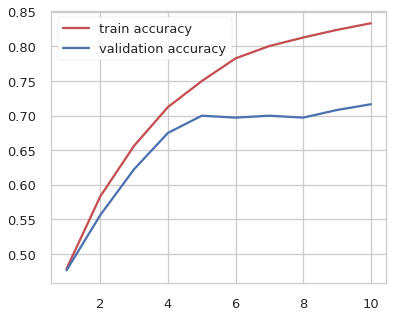

In [ ]:
evaluate_plot(history6)

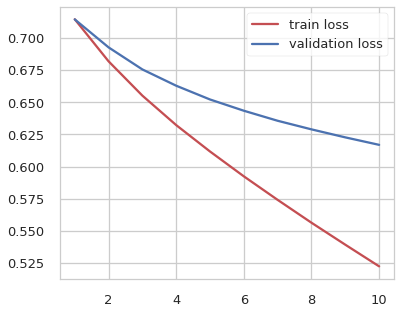

In [ ]:
evaluate_plot(history6, 'loss')

In [ ]:
results6 = model6.predict(x = X_test_sequence, batch_size=64, verbose=0)
#predictions6 = np.argmax(results6, axis=1)
predictions6 = np.where(results6 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions6)

array([[362,  44],
       [158,  76]])

In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred = predictions6))

              precision    recall  f1-score   support

           0       0.70      0.89      0.78       406
           1       0.63      0.32      0.43       234

    accuracy                           0.68       640
   macro avg       0.66      0.61      0.61       640
weighted avg       0.67      0.68      0.65       640



In [ ]:
metrics.fbeta_score(y_test, predictions6, beta=2).round(2)

0.36

In [ ]:
X_train_sequence = tkn.texts_to_sequences(X_train)
X_test_sequence = tkn.texts_to_sequences(X_test)
X_valid_sequence = tkn.texts_to_sequences(X_valid)
X_train_sequence[2]

[110, 789, 791, 595, 790, 20, 1, 201, 290]

In [ ]:
X_train[2]

In [ ]:
X_train_seq_pad = pad_sequences(X_train_sequence, padding="post", maxlen=maxlen)
X_test_seq_pad = pad_sequences(X_test_sequence, padding="post", maxlen=maxlen)
X_valid_seq_pad = pad_sequences(X_valid_sequence, padding="post", maxlen=maxlen)
X_train_seq_pad[2]

array([110, 789, 791, 595, 790,  20,   1, 201, 290,   0,   0,   0],
      dtype=int32)

In [ ]:
embedding_dim = 100

In [ ]:
path_to_glove_file = "/content/drive/MyDrive/Colab Notebooks/Emotional word lists/glove.6B.100d.txt" #"/content/glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))


from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=14)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)
vectorizer.adapt(text_ds)



voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 2143 words (3 misses)


In [ ]:
x_train = vectorizer(np.array([[s] for s in X_train])).numpy()
x_valid = vectorizer(np.array([[s] for s in X_valid])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test])).numpy()

y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

In [ ]:
model = Sequential()
#model.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model.add(layers.Conv1D(200, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=25e-5), 
              loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=epoch, 
                    batch_size=64, 
                    validation_data=(x_valid, y_valid), verbose=1)

Epoch 1/10
51/51 [==============================] - 1s 13ms/step - loss: 0.6718 - accuracy: 0.6291 - val_loss: 0.6006 - val_accuracy: 0.7273
Epoch 2/10
51/51 [==============================] - 0s 10ms/step - loss: 0.6131 - accuracy: 0.6798 - val_loss: 0.5734 - val_accuracy: 0.7383
Epoch 3/10
51/51 [==============================] - 0s 10ms/step - loss: 0.5873 - accuracy: 0.7135 - val_loss: 0.5626 - val_accuracy: 0.7466
Epoch 4/10
51/51 [==============================] - 1s 10ms/step - loss: 0.5664 - accuracy: 0.7331 - val_loss: 0.5501 - val_accuracy: 0.7466
Epoch 5/10
51/51 [==============================] - 0s 10ms/step - loss: 0.5500 - accuracy: 0.7408 - val_loss: 0.5471 - val_accuracy: 0.7493
Epoch 6/10
51/51 [==============================] - 0s 10ms/step - loss: 0.5386 - accuracy: 0.7439 - val_loss: 0.5398 - val_accuracy: 0.7493
Epoch 7/10
51/51 [==============================] - 0s 9ms/step - loss: 0.5205 - accuracy: 0.7675 - val_loss: 0.5347 - val_accuracy: 0.7493
Epoch 8/10
51/

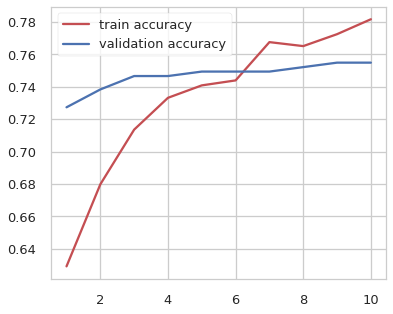

In [ ]:
evaluate_plot(history)

In [ ]:
results6 = model.predict(x = x_test, batch_size=64, verbose=0)
#predictions6 = np.argmax(results6, axis=1)
predictions6 = np.where(results6 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions6)

array([[362,  44],
       [123, 111]])

In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred = predictions6))
metrics.fbeta_score(y_test, predictions6, beta=2).round(2)

              precision    recall  f1-score   support

           0       0.75      0.89      0.81       406
           1       0.72      0.47      0.57       234

    accuracy                           0.74       640
   macro avg       0.73      0.68      0.69       640
weighted avg       0.74      0.74      0.72       640



0.51

In [ ]:
model2 = Sequential()
#model2.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model2.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model2.add(layers.Bidirectional(layers.LSTM(50, activation='relu', 
                                            dropout = 0.1, recurrent_dropout=0.1)))
model2.add(layers.Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(optimizer=optimizers.Adam(learning_rate=35e-5), loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(x = x_train, y = y_train, validation_data=(x_valid, y_valid), batch_size=64, 
                      epochs=epoch, shuffle=True, verbose=2)

Epoch 1/10
51/51 - 9s - loss: 0.6633 - accuracy: 0.6479 - val_loss: 0.6289 - val_accuracy: 0.7135 - 9s/epoch - 172ms/step
Epoch 2/10
51/51 - 2s - loss: 0.6370 - accuracy: 0.6699 - val_loss: 0.5989 - val_accuracy: 0.7025 - 2s/epoch - 42ms/step
Epoch 3/10
51/51 - 2s - loss: 0.6113 - accuracy: 0.6834 - val_loss: 0.5723 - val_accuracy: 0.7300 - 2s/epoch - 42ms/step
Epoch 4/10
51/51 - 2s - loss: 0.5845 - accuracy: 0.7110 - val_loss: 0.5466 - val_accuracy: 0.7548 - 2s/epoch - 42ms/step
Epoch 5/10
51/51 - 2s - loss: 0.5651 - accuracy: 0.7187 - val_loss: 0.5356 - val_accuracy: 0.7576 - 2s/epoch - 42ms/step
Epoch 6/10
51/51 - 2s - loss: 0.5524 - accuracy: 0.7248 - val_loss: 0.5274 - val_accuracy: 0.7548 - 2s/epoch - 43ms/step
Epoch 7/10
51/51 - 2s - loss: 0.5517 - accuracy: 0.7325 - val_loss: 0.5453 - val_accuracy: 0.7686 - 2s/epoch - 42ms/step
Epoch 8/10
51/51 - 2s - loss: 0.5406 - accuracy: 0.7396 - val_loss: 0.5252 - val_accuracy: 0.7603 - 2s/epoch - 42ms/step
Epoch 9/10
51/51 - 2s - loss: 0

In [ ]:
model2.evaluate(x_test, y_test, batch_size=64)

10/10 [==============================] - 1s 9ms/step - loss: 0.5973 - accuracy: 0.7156


[0.5972725749015808, 0.715624988079071]

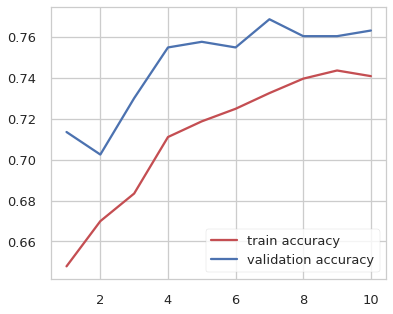

In [ ]:
evaluate_plot(history2)

In [ ]:
results6 = model2.predict(x = x_test, batch_size=64, verbose=0)
#predictions6 = np.argmax(results6, axis=1)
predictions6 = np.where(results6 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions6)

array([[384,  22],
       [160,  74]])

In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred = predictions6))
metrics.fbeta_score(y_test, predictions6, beta=2).round(2)

              precision    recall  f1-score   support

           0       0.71      0.95      0.81       406
           1       0.77      0.32      0.45       234

    accuracy                           0.72       640
   macro avg       0.74      0.63      0.63       640
weighted avg       0.73      0.72      0.68       640



0.36

In [ ]:
model3 = Sequential()
#model3.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model3.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model3.add(layers.LSTM(80, activation='relu', dropout = 0.1, 
                       recurrent_dropout=0.1))
model3.add(Dense(10, activation='relu'))
model3.add(layers.Dropout(0.1))
model3.add(Dense(1, activation='sigmoid'))


model3.compile(optimizer=optimizers.Adam(learning_rate = 25e-5), loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(x = x_train, y = y_train, validation_data=(x_valid, y_valid), batch_size=64, 
                      epochs=epoch, shuffle=True, verbose=2)

Epoch 1/10
51/51 - 8s - loss: 0.6916 - accuracy: 0.6255 - val_loss: 0.6863 - val_accuracy: 0.7135 - 8s/epoch - 164ms/step
Epoch 2/10
51/51 - 4s - loss: 0.6820 - accuracy: 0.6543 - val_loss: 0.6621 - val_accuracy: 0.7107 - 4s/epoch - 70ms/step
Epoch 3/10
51/51 - 3s - loss: 0.6572 - accuracy: 0.6629 - val_loss: 0.6128 - val_accuracy: 0.7218 - 3s/epoch - 51ms/step
Epoch 4/10
51/51 - 1s - loss: 0.6130 - accuracy: 0.6908 - val_loss: 0.5706 - val_accuracy: 0.7466 - 1s/epoch - 29ms/step
Epoch 5/10
51/51 - 1s - loss: 0.5884 - accuracy: 0.7086 - val_loss: 0.5494 - val_accuracy: 0.7631 - 1s/epoch - 29ms/step
Epoch 6/10
51/51 - 1s - loss: 0.5727 - accuracy: 0.7224 - val_loss: 0.5391 - val_accuracy: 0.7603 - 1s/epoch - 29ms/step
Epoch 7/10
51/51 - 1s - loss: 0.5730 - accuracy: 0.7156 - val_loss: 0.5298 - val_accuracy: 0.7658 - 1s/epoch - 29ms/step
Epoch 8/10
51/51 - 1s - loss: 0.5590 - accuracy: 0.7362 - val_loss: 0.5288 - val_accuracy: 0.7686 - 1s/epoch - 28ms/step
Epoch 9/10
51/51 - 1s - loss: 0

In [ ]:
model3.evaluate(x_test, y_test, batch_size=64)

10/10 [==============================] - 0s 8ms/step - loss: 0.5842 - accuracy: 0.7203


[0.5841946601867676, 0.7203124761581421]

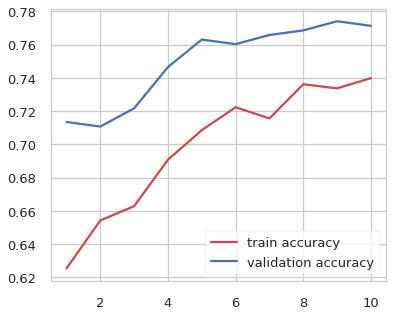

In [ ]:
evaluate_plot(history3)

In [ ]:
results6 = model3.predict(x = X_test_seq_pad, batch_size=64, verbose=0)
#predictions6 = np.argmax(results6, axis=1)
predictions6 = np.where(results6 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions6)

In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred = predictions6))
metrics.fbeta_score(y_test, predictions6, beta=2).round(2)

In [ ]:
model5 = Sequential()
#model5.add(layers.Embedding(vocab, embedding_dim, input_length=maxlen))
model5.add(layers.Embedding(num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False))
model5.add(layers.Bidirectional(layers.GRU(100, activation='relu', 
                                            dropout = 0.1, 
                                            recurrent_dropout=0.1, 
                                            return_sequences=True)))
model5.add(layers.Conv1D(50, 3, activation='relu'))
model5.add(layers.GlobalAveragePooling1D())
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(1, activation='sigmoid'))

model5.compile(optimizer=optimizers.Adam(learning_rate=35e-5), loss='binary_crossentropy', 
               metrics=['accuracy', 
                        keras.metrics.Recall(name = 'recall'), 
                        keras.metrics.TruePositives(name = 'true_pos')])
history5 = model5.fit(x_train, y_train, epochs=epoch, batch_size=64, 
                    validation_data=(x_valid, y_valid), verbose=2)

Epoch 1/10
51/51 - 16s - loss: 0.6666 - accuracy: 0.6509 - recall: 0.0433 - true_pos: 50.0000 - val_loss: 0.6081 - val_accuracy: 0.7163 - val_recall: 0.0648 - val_true_pos: 7.0000 - 16s/epoch - 307ms/step
Epoch 2/10
51/51 - 5s - loss: 0.6122 - accuracy: 0.6819 - recall: 0.2097 - true_pos: 242.0000 - val_loss: 0.5545 - val_accuracy: 0.7300 - val_recall: 0.1759 - val_true_pos: 19.0000 - 5s/epoch - 106ms/step
Epoch 3/10
51/51 - 5s - loss: 0.5829 - accuracy: 0.7101 - recall: 0.3449 - true_pos: 398.0000 - val_loss: 0.5365 - val_accuracy: 0.7576 - val_recall: 0.3981 - val_true_pos: 43.0000 - 5s/epoch - 104ms/step
Epoch 4/10
51/51 - 4s - loss: 0.5619 - accuracy: 0.7310 - recall: 0.4454 - true_pos: 514.0000 - val_loss: 0.5222 - val_accuracy: 0.7658 - val_recall: 0.3241 - val_true_pos: 35.0000 - 4s/epoch - 72ms/step
Epoch 5/10
51/51 - 4s - loss: 0.5536 - accuracy: 0.7245 - recall: 0.4324 - true_pos: 499.0000 - val_loss: 0.5196 - val_accuracy: 0.7658 - val_recall: 0.4259 - val_true_pos: 46.0000 

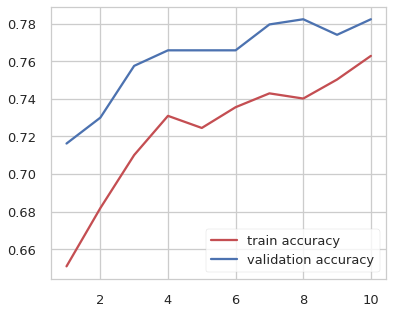

In [ ]:
evaluate_plot(history5)

In [ ]:
model5.evaluate(x_test, y_test, batch_size=64)

10/10 [==============================] - 1s 16ms/step - loss: 0.5674 - accuracy: 0.7281 - recall: 0.4188 - true_pos: 98.0000


[0.5673527717590332, 0.7281249761581421, 0.4188034236431122, 98.0]

In [ ]:
results6 = model5.predict(x = x_test, batch_size=64, verbose=0)
#predictions6 = np.argmax(results6, axis=1)
predictions6 = np.where(results6 > 0.5, 1, 0)
metrics.confusion_matrix(y_true = y_test, y_pred = predictions6)

array([[384,  22],
       [162,  72]])

In [ ]:
print(metrics.classification_report(y_true = y_test, y_pred = predictions6))
metrics.fbeta_score(y_test, predictions6, beta=2).round(2)